In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import roc_auc_score
import scipy.stats.mstats as mstats
# from libauc.losses import AUCMLoss
# from libauc.metrics import auc_roc_score
# import torch
matplotlib.rcParams.update({'font.size': 22})

In [2]:
valid_error = [1,2,3,4,5]
print('valid_MAE={:.3f}, valid_RMSE={:.3f}, valid_Pearson={:.3f}, valid_Spearman={:.3f}, valid_R2={:.3f}'.format(*valid_error))

valid_MAE=1.000, valid_RMSE=2.000, valid_Pearson=3.000, valid_Spearman=4.000, valid_R2=5.000


In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 
print(parkinsons_telemonitoring.metadata) 
  
# variable information 
print(parkinsons_telemonitoring.variables) 
X = X.to_numpy()
y = y.to_numpy()

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'published_in': 'IEEE Transactions on Biomedical Engineering', 

(5875, 19)
(5875, 2)


/local/scratch/dixzhu/slrmtmp.42431519/ipykernel_96654/1097441443.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


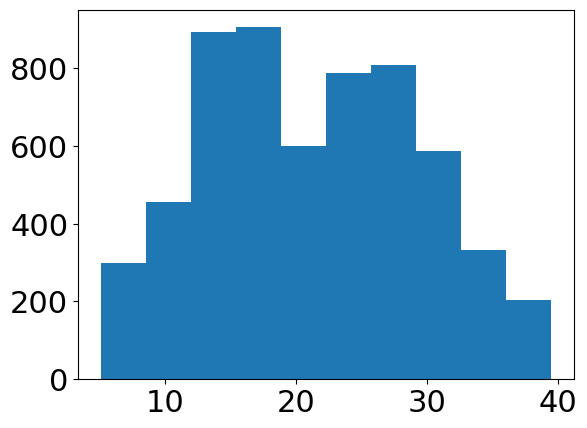

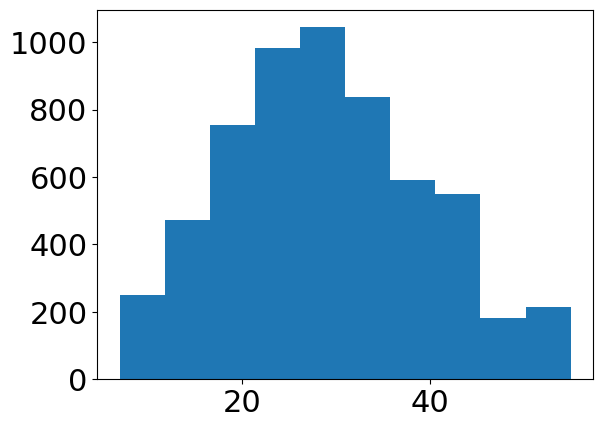

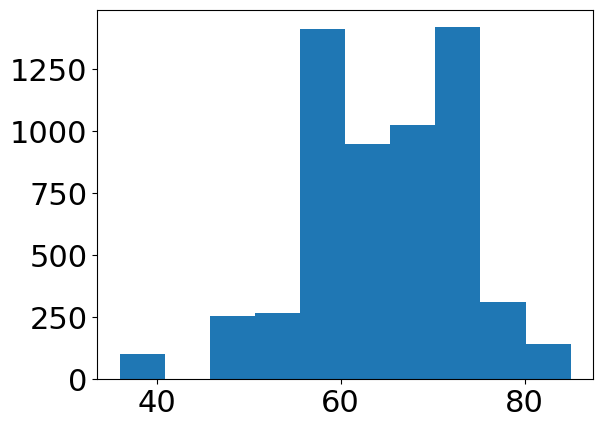

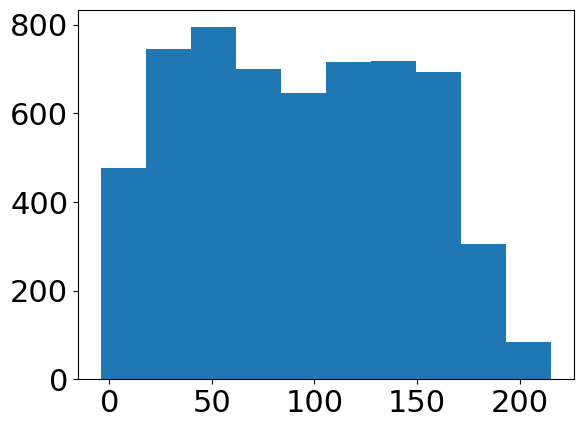

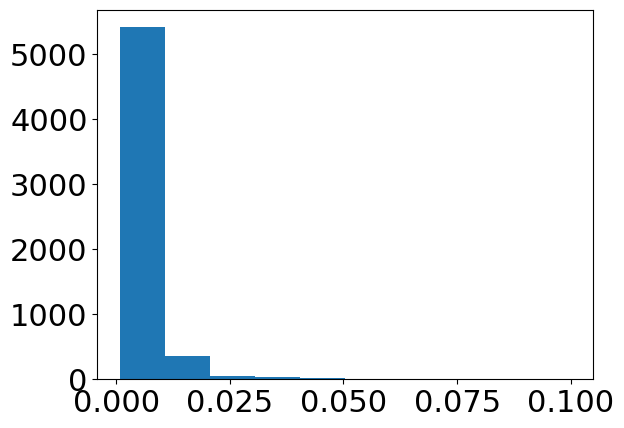

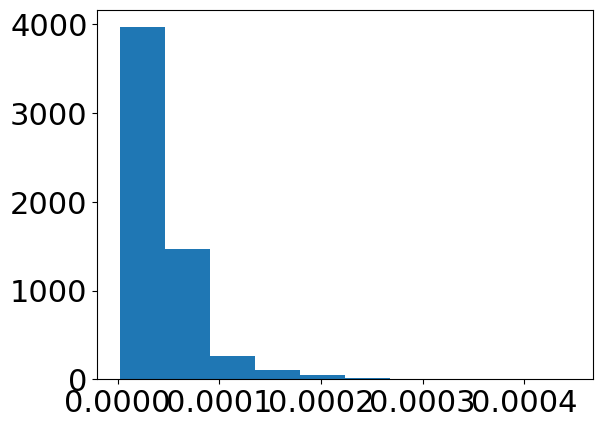

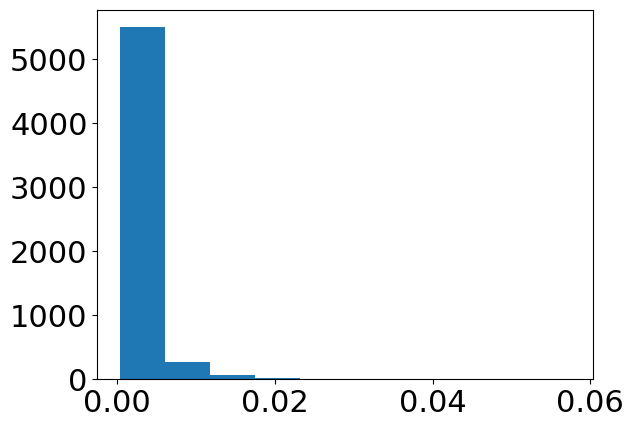

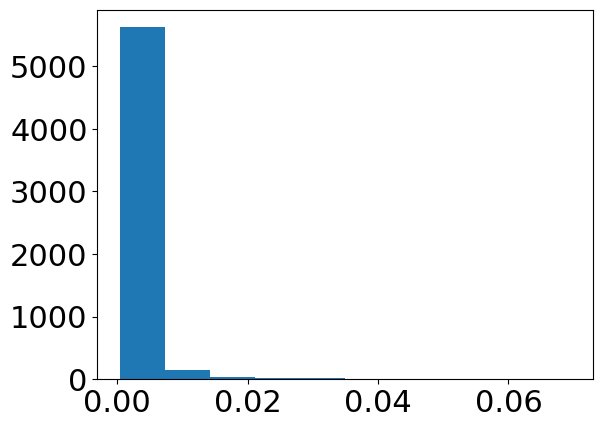

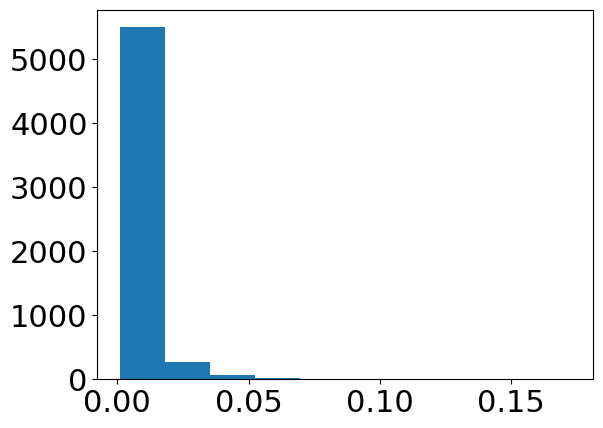

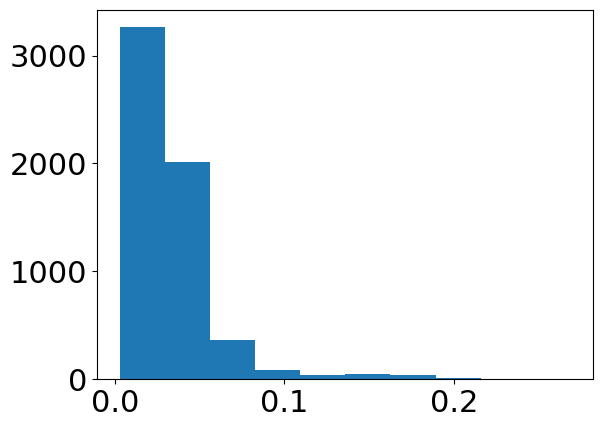

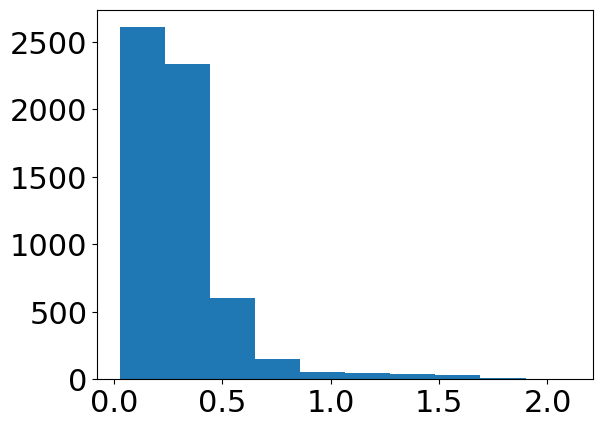

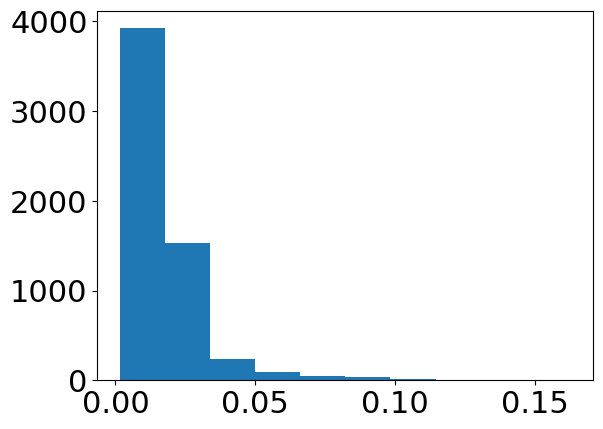

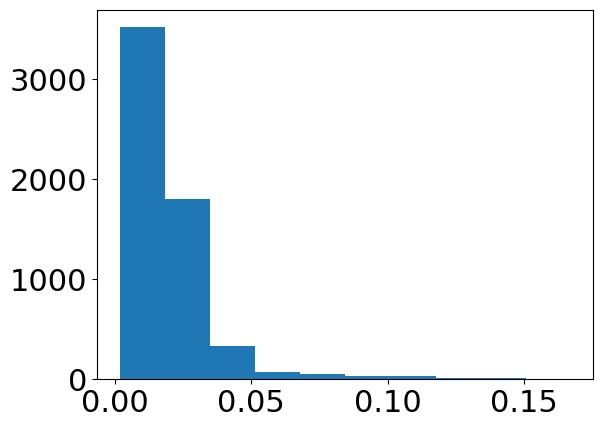

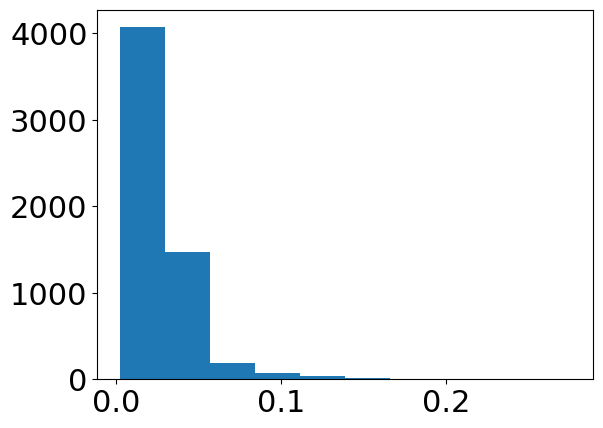

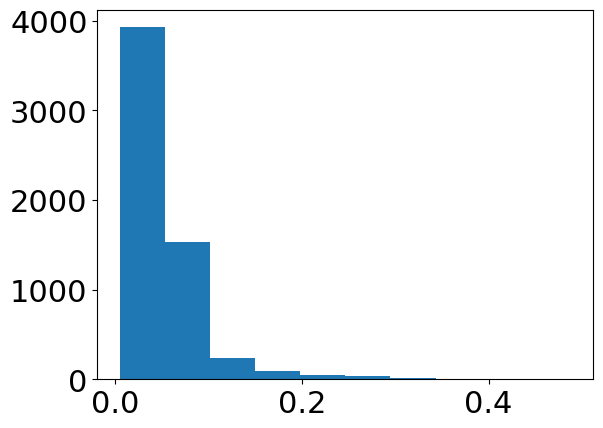

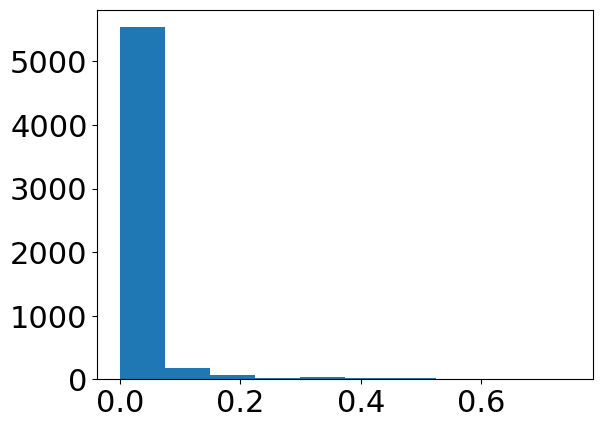

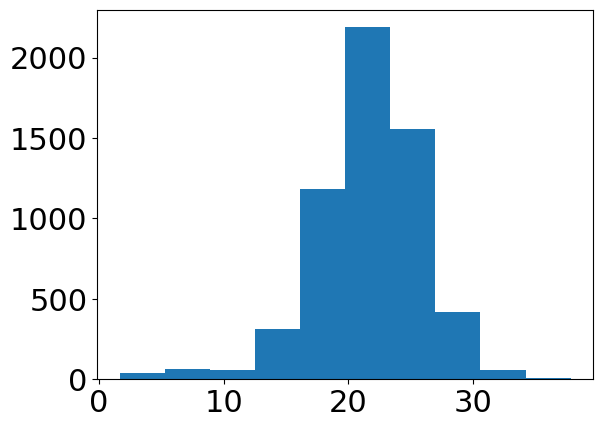

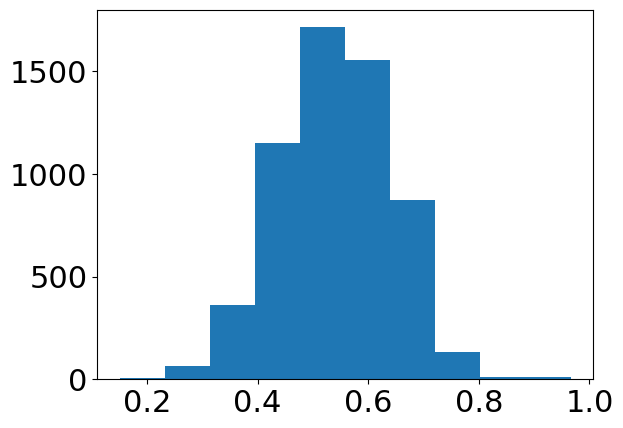

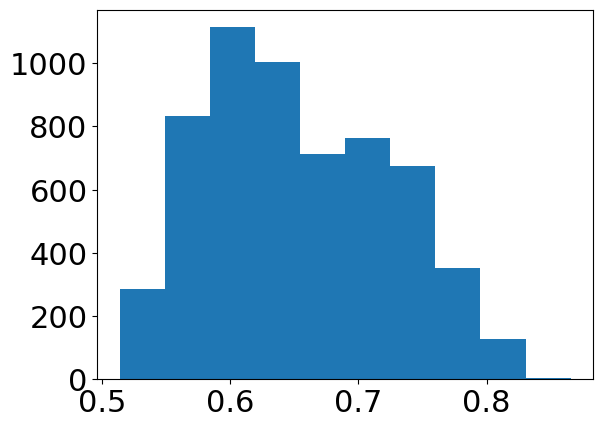

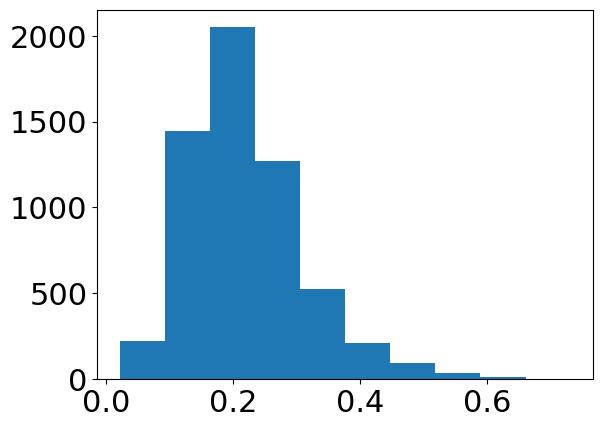

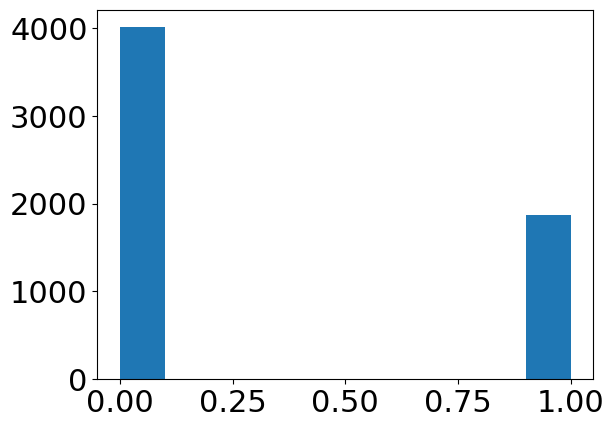

In [10]:
print(X.shape)
print(y.shape)
plt.hist(y[:,0])
plt.figure()
plt.hist(y[:,1])

for i in range(X.shape[1]):
    plt.figure()
    plt.hist(X[:,i])

(241600, 18)
[116.37    78.705   80.565  ...  35.16    28.4525  17.8175]


(array([ 5517., 53037., 62376., 24495., 31191., 28162., 16694., 12454.,
         4492.,  3182.]),
 array([2.58907896, 3.1415888 , 3.69409863, 4.24660847, 4.79911831,
        5.35162815, 5.90413798, 6.45664782, 7.00915766, 7.56166749,
        8.11417733]),
 <BarContainer object of 10 artists>)

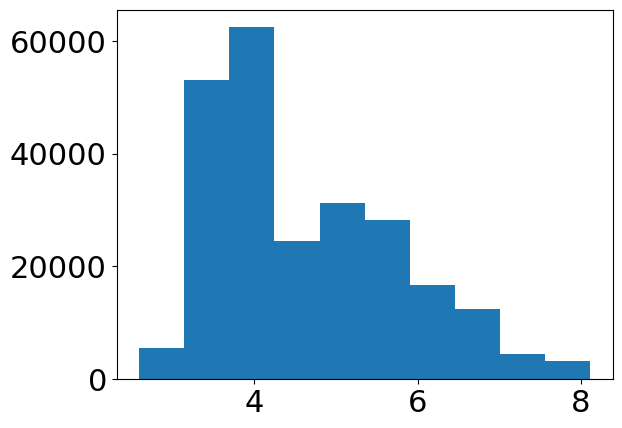

In [12]:
dat=np.genfromtxt("../Data/sgemm_product.csv", delimiter=",")
# print(dat[1:,])
data = dat[1:,]
print(data.shape)
X = data[:,:14]
y = data[:,14:].mean(axis=-1)
print(y)
plt.hist(np.log(y))
# ids = np.random.permutation(X.shape[0])
# np.savez('../Data/gpu.npz',X=X,y=y,ids=ids)

[[ 0.75744723 -0.69521045  0.03277187 ... -0.97543219 -1.81071884
   0.13891975]
 [-0.66165665 -0.61879381  0.01605588 ... -0.26907618  0.83774863
  -0.68965812]
 [-0.66165665 -0.71219192  0.00764453 ... -0.26907618  0.83774863
  -0.68965812]
 ...
 [-0.18862202 -0.2218518  -0.00904959 ...  0.24463729 -1.56994907
  -0.08705603]
 [-2.08076053  0.28759248 -0.00247749 ... -0.26907618  0.83774863
  -0.68965812]
 [-0.18862202 -0.82681689  0.04367671 ...  0.67273184 -0.92789635
   0.41511238]]


(array([1.0000e+00, 3.0000e+00, 3.3000e+01, 1.6700e+02, 8.9700e+03,
        2.2914e+04, 6.1730e+03, 1.2170e+03, 1.5400e+02, 1.2000e+01]),
 array([ 0.        ,  1.3645078 ,  2.72901561,  4.09352341,  5.45803122,
         6.82253902,  8.18704683,  9.55155463, 10.91606244, 12.28057024,
        13.64507805]),
 <BarContainer object of 10 artists>)

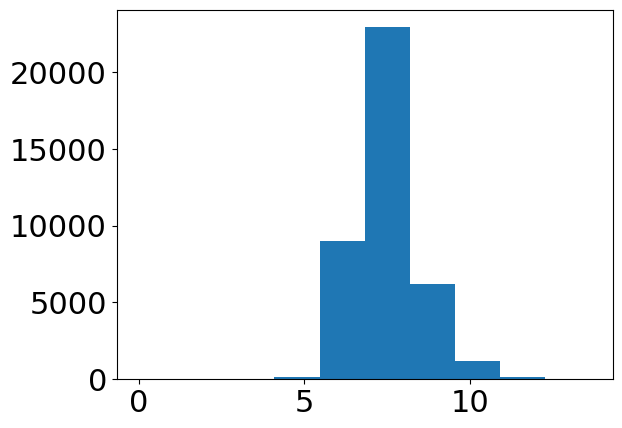

In [15]:
# dat=np.genfromtxt("../Data/OnlineNewsPopularity.csv", delimiter=",")
# print(dat)
# data = dat[1:,2:]
# print(data.shape)
# print(data)
# X = data[:,:-1]
# y = data[:,-1]
# print(y)
# ids = np.random.permutation(X.shape[0])
# np.savez('../Data/news_pop.npz',X=X,y=y,ids=ids)

dat = np.load('../Data/news_pop.npz')
X = dat['X']
y = dat['y']
ids = dat['ids']
X = (X - X.mean(axis=0))/X.std(axis=0)
print(X)
plt.hist(np.log(y))
# np.savez('../Data/news_pop_std.npz',X=X, y=y, ids=ids)

In [3]:
def metric_isbetter(metric, a, b):
    if metric.split('_')[1] in ['MAE', 'RMSE']:
        return b < a
    else:
        return b > a
    
def metric_worst(metric):
    if metric.split('_')[1] in ['MAE', 'RMSE']:
        return 1e10
    else:
        return -1e10

In [6]:
# baselines = ['MAE (vanilla)','MSE', 'Huber', 'focal (MAE)', 'focal (MSE)', 'ConR', 'FAR']
baselines = ['MAE (vanilla)','MSE', 'Huber', 'focal (MAE)', 'focal (MSE)', 'ranksim', 'RNC', 'ConR', 'FAR', 'MAE + Pearson']#, 'MAE + Pearson'] #'FAR-LOG', 'MAE + Pearson']
# namemap = {'MAE + Pearson': 'pearson', 'MAE (vanilla)':'l1', 'MSE':'MSE', 'Huber':'huber', 'focal (MAE)':'focal-l1', 'focal (MSE)':'focal-mse', 'ranksim':'ranksim', 'RNC':'RNC', 'ConR':'ConR', 'FAR':'FAR', 'FAR-LOG':'pearson-dro'}
namemap = {'MAE + Pearson': 'pearson', 'MAE (vanilla)':'l1', 'MSE':'MSE', 'Huber':'huber', 'focal (MAE)':'focal-l1', 'focal (MSE)':'focal-mse', 'ranksim':'ranksim', 'RNC':'RNC', 'ConR':'ConR', 'FAR':'FARLOG-01-1-10', 'FAR-LOG':'pearson-dro'}
dataname = 'wine'
basic_path = '../Results/AlignedRegression/abalone_l1_lr=1e-1_decay=1e-3.out'.replace('abalone',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
if dataname in ['supercon']:
    lrs = ['1e-3', '1e-4', '1e-5']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    print(baseline)
    if dataname in ['supercon'] and baseline in ['RNC','FAR']:
        tmp_lrs = ['1e-1', '1e-2', '1e-3']
#     if dataname in ['parkinson-total','parkinson-motor']:
#         if baseline in ['RNC','FAR']:
#             tmp_lrs = ['5e-1', '1e-1', '1e-2', '1e-3']
#         elif baseline in ['MSE','ranksim']:
#             tmp_lrs = ['1e-1', '1e-2', '1e-3', '1e-4']
    for decay in decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', namemap[baseline]).replace('lr=1e-1','lr='+lr).replace('decay=1e-3','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                res[metric] = np.array(res[metric]).reshape(5, 3,-1)
            results[baseline][decay][lr] = res
print(results)

MAE (vanilla)
MSE
Huber
focal (MAE)
focal (MSE)
ranksim
RNC
ConR
FAR
MAE + Pearson
{'MAE (vanilla)': {'1e-3': {'1e-1': {'train_MAE': array([[[1.35191000e+01, 5.80924102e+04, 2.58897637e+04, ...,
         6.43300000e-01, 6.42500000e-01, 6.46400000e-01],
        [1.15847000e+01, 1.86078800e+02, 8.78972000e+01, ...,
         6.47100000e-01, 6.49400000e-01, 6.44500000e-01],
        [9.87160000e+01, 7.19865600e+02, 1.06359590e+03, ...,
         3.71957500e+02, 3.71585400e+02, 3.71203300e+02]],

       [[6.77020000e+00, 6.02098125e+04, 1.93003740e+03, ...,
         1.48684050e+03, 1.48642220e+03, 1.48601030e+03],
        [1.19353900e+02, 1.36552490e+21, 3.46369034e+30, ...,
         1.33949131e+15, 1.33943763e+15, 1.33938448e+15],
        [8.31630000e+00, 4.14273463e+20,            inf, ...,
                    nan,            nan,            nan]],

       [[6.19789000e+01, 4.04887900e+02, 2.63884000e+01, ...,
         6.43300000e-01, 6.43700000e-01, 6.42900000e-01],
        [7.47710000e+00

In [10]:
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = results['MAE (vanilla)']['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric.replace('test','valid')][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)

for metric in eval_metrics:
#     print(metric)
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -2
for metric in eval_metrics:
#     print(metric)
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric]['MAE (vanilla)']['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)
#     print(output)
#     print(np.around(max(maxvalue), 2))
    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric]['MAE (vanilla)']['test'])
    ttest2 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'test_MAE': {'MAE (vanilla)': {'valid': array([0.6409, 0.6226, 0.6517, 0.5877, 0.6605]), 'test': array([0.6273, 0.6298, 0.6307, 0.6295, 0.6234])}, 'MSE': {'valid': array([0.6472, 0.6294, 0.6403, 0.5899, 0.6588]), 'test': array([0.6246, 0.631 , 0.6197, 0.626 , 0.6256])}, 'Huber': {'valid': array([0.6164, 0.6189, 0.6404, 0.5845, 0.6517]), 'test': array([0.607 , 0.625 , 0.6176, 0.6099, 0.6168])}, 'focal (MAE)': {'valid': array([0.6197, 0.6251, 0.64  , 0.5885, 0.6409]), 'test': array([0.6125, 0.6398, 0.6181, 0.6348, 0.615 ])}, 'focal (MSE)': {'valid': array([0.6481, 0.6299, 0.6439, 0.5959, 0.6605]), 'test': array([0.6243, 0.6358, 0.6239, 0.6281, 0.6331])}, 'ranksim': {'valid': array([0.6418, 0.6166, 0.6332, 0.5885, 0.6702]), 'test': array([0.6201, 0.6307, 0.6188, 0.6348, 0.63  ])}, 'RNC': {'valid': array([0.6554, 0.629 , 0.6562, 0.5877, 0.6764]), 'test': array([0.6339, 0.6337, 0.6254, 0.6314, 0.6323])}, 'ConR': {'valid': array([0.6426, 0.6154, 0.6384, 0.5885, 0.6682]), 'test': array([0.62

In [11]:
eval_metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
evals = {}
epochs = results['MAE (vanilla)']['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric.replace('train','train')][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)



for metric in eval_metrics:
#     print(metric)
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -2
for metric in eval_metrics:
#     print(metric)
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric]['MAE (vanilla)']['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)
#     print(output)
#     print(np.around(max(maxvalue), 2))
    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric]['MAE (vanilla)']['test'])
    ttest2 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'train_MAE': {'MAE (vanilla)': {'valid': array([0.6285, 0.6239, 0.6186, 0.6356, 0.6125]), 'test': array([0.6285, 0.6239, 0.6186, 0.6356, 0.6125])}, 'MSE': {'valid': array([0.6367, 0.6371, 0.629 , 0.6433, 0.6085]), 'test': array([0.6367, 0.6371, 0.629 , 0.6433, 0.6085])}, 'Huber': {'valid': array([0.6074, 0.6253, 0.6285, 0.6194, 0.6105]), 'test': array([0.6074, 0.6253, 0.6285, 0.6194, 0.6105])}, 'focal (MAE)': {'valid': array([0.6135, 0.6364, 0.6163, 0.6236, 0.6025]), 'test': array([0.6135, 0.6364, 0.6163, 0.6236, 0.6025])}, 'focal (MSE)': {'valid': array([0.6372, 0.6395, 0.6332, 0.6485, 0.6096]), 'test': array([0.6372, 0.6395, 0.6332, 0.6485, 0.6096])}, 'ranksim': {'valid': array([0.6225, 0.6351, 0.6281, 0.6417, 0.6065]), 'test': array([0.6225, 0.6351, 0.6281, 0.6417, 0.6065])}, 'RNC': {'valid': array([0.6399, 0.644 , 0.6319, 0.6313, 0.6276]), 'test': array([0.6399, 0.644 , 0.6319, 0.6313, 0.6276])}, 'ConR': {'valid': array([0.6228, 0.6285, 0.6299, 0.6488, 0.6049]), 'test': array([0.6

In [2]:
metric_pretrain = {}
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman', 'test_R2']
baselines = ['L1','MSE','Huber','Focal-L1','Focal-MSE','FAR']
for metric in eval_metrics:
    metric_pretrain[metric] = {}
    for baseline in baselines:
        metric_pretrain[metric][baseline] = {}

metric_pretrain['test_MAE']['L1'] = [6.098, 6.081, 6.195, 6.125, 6.119]
metric_pretrain['test_RMSE']['L1'] = [8.061, 8.030, 8.141, 8.078, 8.074]
metric_pretrain['test_Pearson']['L1'] = [0.924, 0.925, 0.924, 0.924, 0.925]
metric_pretrain['test_Spearman']['L1'] = [0.927, 0.927, 0.927, 0.927, 0.927]
metric_pretrain['test_R2']['L1'] = [0.853, 0.854, 0.850, 0.853, 0.853]


metric_pretrain['test_MAE']['MSE'] = [6.065, 6.066, 6.149, 6.219, 6.149]
metric_pretrain['test_RMSE']['MSE'] = [8.051, 8.052, 8.119, 8.152, 8.119]
metric_pretrain['test_Pearson']['MSE'] = [0.924, 0.924, 0.923, 0.924, 0.923]
metric_pretrain['test_Spearman']['MSE'] = [0.927, 0.927, 0.926, 0.927, 0.926]
metric_pretrain['test_R2']['MSE'] = [0.854, 0.854, 0.851, 0.850, 0.851]

metric_pretrain['test_MAE']['Huber'] = [6.060, 6.076, 6.061, 6.134, 6.287]
metric_pretrain['test_RMSE']['Huber'] = [8.050, 8.084, 8.051, 8.125, 8.232]
metric_pretrain['test_Pearson']['Huber'] = [0.925, 0.924, 0.924, 0.925, 0.924]
metric_pretrain['test_Spearman']['Huber'] = [0.927, 0.927, 0.927, 0.927, 0.927]
metric_pretrain['test_R2']['Huber'] = [0.854, 0.852, 0.854, 0.851, 0.847]

metric_pretrain['test_MAE']['Focal-MSE'] = [6.092, 6.175, 6.124, 6.179, 6.126]
metric_pretrain['test_RMSE']['Focal-MSE'] = [8.059, 8.146, 8.099, 8.162, 8.100]
metric_pretrain['test_Pearson']['Focal-MSE'] = [0.924, 0.924, 0.923, 0.924, 0.924]
metric_pretrain['test_Spearman']['Focal-MSE'] = [0.927, 0.926, 0.926, 0.926, 0.927]
metric_pretrain['test_R2']['Focal-MSE'] = [0.853, 0.850, 0.852, 0.850, 0.852]


metric_pretrain['test_MAE']['Focal-L1'] = [6.136, 6.075, 6.153, 6.047, 6.101]
metric_pretrain['test_RMSE']['Focal-L1'] = [8.083, 8.046, 8.124, 8.046, 8.064]
metric_pretrain['test_Pearson']['Focal-L1'] = [0.924, 0.924, 0.925, 0.924, 0.924]
metric_pretrain['test_Spearman']['Focal-L1'] = [0.927, 0.927, 0.927, 0.927, 0.927]
metric_pretrain['test_R2']['Focal-L1'] = [0.853, 0.854, 0.851, 0.854, 0.853]

metric_pretrain['test_MAE']['FAR'] = [6.049, 6.107, 6.045, 6.072, 6.071]
metric_pretrain['test_RMSE']['FAR'] = [8.045, 8.080, 8.046, 8.044, 8.056]
metric_pretrain['test_Pearson']['FAR'] = [0.924, 0.924, 0.924, 0.924, 0.924]
metric_pretrain['test_Spearman']['FAR'] = [0.927, 0.927, 0.927, 0.927, 0.927]
metric_pretrain['test_R2']['FAR'] = [0.854, 0.853, 0.854, 0.854, 0.853]


for metric in eval_metrics:
#     print(metric)
    output = ''
    for baseline in baselines:
        values = metric_pretrain[metric][baseline]
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = metric_pretrain[metric][baseline]
        mean = np.mean(values)
        mean_baseline = np.mean(metric_pretrain[metric]['L1'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)
    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(metric_pretrain[metric][subopt])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(metric_pretrain[metric]['FAR'], metric_pretrain[metric]['L1'])
    ttest2 = mstats.ttest_ind(metric_pretrain[metric]['FAR'], metric_pretrain[metric][subopt])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

6.124(0.039)	6.13(0.058)	6.124(0.086)	6.102(0.039)	6.139(0.033)	6.069(0.022)	
8.077(0.036)	8.099(0.04)	8.108(0.068)	8.073(0.029)	8.113(0.037)	8.054(0.014)	
0.924(0.0)	0.924(0.0)	0.924(0.0)	0.924(0.0)	0.924(0.0)	0.924(0.0)	
0.927(0.0)	0.927(0.0)	0.927(0.0)	0.927(0.0)	0.926(0.0)	0.927(0.0)	
0.853(0.001)	0.852(0.002)	0.852(0.003)	0.853(0.001)	0.851(0.001)	0.854(0.0)	
0.89(0.55)	0.04(0.17)
0.28(0.23)	0.28(0.29)
-0.04(-0.04)	0.14(0.14)
0.0(0.0)	1.0(1.0)
0.12(0.07)	0.2(0.35)


In [4]:
# training from scratch results

metric_pretrain = {}
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman', 'test_R2']
baselines = ['L1','MSE','Huber','Focal-L1','Focal-MSE', 'ranksim', 'ConR','FAR']
for metric in eval_metrics:
    metric_pretrain[metric] = {}
    for baseline in baselines:
        metric_pretrain[metric][baseline] = {}

metric_pretrain['test_MAE']['L1'] = [6.451, 6.341, 6.501, 6.451, 6.501]
metric_pretrain['test_RMSE']['L1'] = [8.487, 8.385, 8.592, 8.487, 8.592]
metric_pretrain['test_Pearson']['L1'] = [0.919, 0.917, 0.915, 0.919, 0.915]
metric_pretrain['test_Spearman']['L1'] = [0.921, 0.920, 0.917, 0.921, 0.917]
metric_pretrain['test_R2']['L1'] = [0.837, 0.841, 0.833, 0.837, 0.833]


metric_pretrain['test_MAE']['MSE'] = [6.398, 6.603, 6.582, 6.398, 6.603]
metric_pretrain['test_RMSE']['MSE'] = [8.552, 8.651, 8.635, 8.552, 8.651]
metric_pretrain['test_Pearson']['MSE'] = [0.915, 0.915, 0.912, 0.915, 0.915]
metric_pretrain['test_Spearman']['MSE'] = [0.918, 0.917, 0.914, 0.918, 0.917]
metric_pretrain['test_R2']['MSE'] = [0.835, 0.831, 0.832, 0.835, 0.831]

metric_pretrain['test_MAE']['Huber'] = [6.415, 6.332, 6.440, 6.332, 6.415]
metric_pretrain['test_RMSE']['Huber'] = [8.431, 8.370, 8.490, 8.370, 8.431]
metric_pretrain['test_Pearson']['Huber'] = [0.918, 0.919, 0.917, 0.919, 0.918]
metric_pretrain['test_Spearman']['Huber'] = [0.920, 0.921, 0.920, 0.921, 0.920]
metric_pretrain['test_R2']['Huber'] = [0.840, 0.842, 0.837, 0.842, 0.840]

metric_pretrain['test_MAE']['FAR'] = [6.31, 6.254, 6.303, 6.326, 6.238]
metric_pretrain['test_RMSE']['FAR'] = [8.218, 8.284, 8.266, 8.353, 8.217]
metric_pretrain['test_Pearson']['FAR'] = [0.922, 0.922, 0.922, 0.919, 0.922]
metric_pretrain['test_Spearman']['FAR'] = [0.923, 0.924, 0.924, 0.920, 0.924]
metric_pretrain['test_R2']['FAR'] = [0.848, 0.845, 0.846, 0.842, 0.848]

metric_pretrain['test_MAE']['ranksim'] = [6.554, 6.633, 6.411, 6.501, 6.411]
metric_pretrain['test_RMSE']['ranksim'] = [8.707, 8.887, 8.396, 8.592, 8.396]
metric_pretrain['test_Pearson']['ranksim'] = [0.912, 0.910, 0.921, 0.915, 0.921]
metric_pretrain['test_Spearman']['ranksim'] = [0.915, 0.913, 0.923, 0.917, 0.923]
metric_pretrain['test_R2']['ranksim'] = [0.829, 0.822, 0.841, 0.833, 0.841]

metric_pretrain['test_MAE']['ConR'] = [6.405, 6.451, 6.456, 6.450, 6.387]
metric_pretrain['test_RMSE']['ConR'] = [8.495, 8.528, 8.536, 8.492, 8.397]
metric_pretrain['test_Pearson']['ConR'] = [0.915, 0.914, 0.916, 0.916, 0.921]
metric_pretrain['test_Spearman']['ConR'] = [0.917, 0.916, 0.918, 0.919, 0.924]
metric_pretrain['test_R2']['ConR'] = [0.837, 0.836, 0.836, 0.837, 0.841]


metric_pretrain['test_MAE']['Focal-L1'] = [6.428, 6.411, 6.393, 6.327, 6.427, 6.435]
metric_pretrain['test_RMSE']['Focal-L1'] = [8.432, 8.396, 8.407, 8.557, 8.557, 8.505]
metric_pretrain['test_Pearson']['Focal-L1'] = [0.919, 0.921, 0.918, 0.916, 0.917]
metric_pretrain['test_Spearman']['Focal-L1'] = [0.921, 0.923, 0.920, 0.918, 0.918, 0.920]
metric_pretrain['test_R2']['Focal-L1'] = [0.839, 0.841, 0.840, 0.835, 0.835]


metric_pretrain['test_MAE']['Focal-MSE'] = [6.447, 6.685, 6.568, 6.686, 6.447]
metric_pretrain['test_RMSE']['Focal-MSE'] = [8.494, 8.723, 8.652, 8.723, 8.494]
metric_pretrain['test_Pearson']['Focal-MSE'] = [0.915, 0.913, 0.913, 0.913, 0.915]
metric_pretrain['test_Spearman']['Focal-MSE'] = [0.917, 0.915, 0.915, 0.915, 0.917]
metric_pretrain['test_R2']['Focal-MSE'] = [0.837,0.828, 0.831, 0.828, 0.837]




for metric in eval_metrics:
#     print(metric)
    output = ''
    for baseline in baselines:
        values = metric_pretrain[metric][baseline]
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = metric_pretrain[metric][baseline]
        mean = np.mean(values)
        mean_baseline = np.mean(metric_pretrain[metric]['L1'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)
    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(metric_pretrain[metric][subopt])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(metric_pretrain[metric]['FAR'], metric_pretrain[metric]['L1'])
    ttest2 = mstats.ttest_ind(metric_pretrain[metric]['FAR'], metric_pretrain[metric][subopt])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

6.449(0.058)	6.517(0.097)	6.387(0.046)	6.404(0.037)	6.567(0.107)	6.502(0.085)	6.43(0.028)	6.286(0.034)	
8.509(0.078)	8.608(0.046)	8.418(0.045)	8.476(0.067)	8.617(0.104)	8.596(0.188)	8.49(0.049)	8.268(0.05)	
0.917(0.002)	0.914(0.001)	0.918(0.001)	0.918(0.002)	0.914(0.001)	0.916(0.005)	0.916(0.002)	0.921(0.001)	
0.919(0.002)	0.917(0.001)	0.92(0.0)	0.92(0.002)	0.916(0.001)	0.918(0.004)	0.919(0.003)	0.923(0.002)	
0.836(0.003)	0.833(0.002)	0.84(0.002)	0.838(0.003)	0.832(0.004)	0.833(0.007)	0.837(0.002)	0.846(0.002)	
2.52(1.58)	0.0(0.01)
2.83(1.79)	0.0(0.0)
0.48(0.35)	0.0(0.0)
0.41(0.28)	0.01(0.01)
1.15(0.67)	0.0(0.0)


In [50]:
baselines = ['FARLOG-01-1-10', 'FARLOG-05-1-2', 'FARLOG-tune-alpha']
dataname = 'parkinson-motor'
basic_path = '../Code/ContrastiveRegression/results/abalone_l1_lr=1e-1_decay=1e-3.out'.replace('abalone',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    print(baseline)
    for decay in decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', baseline).replace('lr=1e-1','lr='+lr).replace('decay=1e-3','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                if baseline == 'FARLOG-tune-alpha':
                    res[metric] = np.array(res[metric]).reshape(5, 8,-1)
                else:
                    res[metric] = np.array(res[metric]).reshape(5, 3,-1)
            results[baseline][decay][lr] = res
print(results)

FARLOG-01-1-10
FARLOG-05-1-2
FARLOG-tune-alpha
{'FARLOG-01-1-10': {'1e-3': {'1e-1': {'train_MAE': array([[[21.2822, 21.1989, 20.8679, ...,  1.7121,  1.7196,  1.7019],
        [21.0281, 20.4879, 18.0012, ...,  1.979 ,  1.966 ,  1.9723],
        [21.0056, 19.8822, 13.8768, ...,  2.03  ,  2.0409,  2.0221]],

       [[21.1312, 21.2232, 21.5049, ...,  1.5567,  1.5683,  1.5517],
        [20.8825, 20.4381, 18.5245, ...,  1.8322,  1.8358,  1.8406],
        [21.2263, 19.5915, 11.1966, ...,  2.0127,  2.0131,  2.0044]],

       [[21.1899, 21.2253, 21.4724, ...,  1.8919,  1.8868,  1.8746],
        [21.2025, 20.6914, 17.7197, ...,  1.9889,  1.9796,  1.9785],
        [21.0237, 19.6729, 12.2784, ...,  1.86  ,  1.8309,  1.8423]],

       [[21.1501, 21.1875, 21.1203, ...,  1.7464,  1.759 ,  1.7284],
        [20.9827, 20.494 , 18.2247, ...,  2.1142,  2.113 ,  2.1006],
        [21.3168, 20.6339, 17.2225, ...,  1.9224,  1.9309,  1.926 ]],

       [[21.3883, 21.3294, 20.8841, ...,  1.7136,  1.7188,  1.6915

In [51]:
paras = ['0.1', '0.2', '0.25', '0.4', '0.5', '0.8', '1', '1.25', '2', '2.5', '4', '5', '10']
FAR_res = {}
for decay in decays:
    FAR_res[decay] = {}
    for lr in lrs:
        FAR_res[decay][lr]={}
        for metric in metrics:
            FAR_res[decay][lr][metric]={}
            res = []
            for i in range(5): # replicas
                res1 = results['FARLOG-01-1-10'][decay][lr][metric][i,0,:]
                res1 = np.expand_dims(res1,[0,1])
                res2 = results['FARLOG-tune-alpha'][decay][lr][metric][i,0:3,:]
                res2 = np.expand_dims(res2,[0])
                res3 = results['FARLOG-05-1-2'][decay][lr][metric][i,0,:]
                res3 = np.expand_dims(res3,[0,1])
                res4 = results['FARLOG-tune-alpha'][decay][lr][metric][i,3,:]
                res4 = np.expand_dims(res4,[0,1])
                res5 = results['FARLOG-01-1-10'][decay][lr][metric][i,1,:]
                res5 = np.expand_dims(res5,[0,1])
                res6 = results['FARLOG-tune-alpha'][decay][lr][metric][i,4,:]
                res6 = np.expand_dims(res6,[0,1])
                res7 = results['FARLOG-05-1-2'][decay][lr][metric][i,2,:]
                res7 = np.expand_dims(res7,[0,1])
                res8 = results['FARLOG-tune-alpha'][decay][lr][metric][i,5:8,:]
                res8 = np.expand_dims(res8,[0])
                res9 = results['FARLOG-01-1-10'][decay][lr][metric][i,2,:]
                res9 = np.expand_dims(res9,[0,1])
                tmp = [res1, res2, res3, res4, res5, res6, res7, res8, res9]
                tmp = np.concatenate(tmp, axis=1)
                res.append(tmp)
            res = np.concatenate(res, axis=0)
            FAR_res[decay][lr][metric] = res
print(FAR_res)

{'1e-3': {'1e-1': {'train_MAE': array([[[21.2822, 21.1989, 20.8679, ...,  1.7121,  1.7196,  1.7019],
        [21.2614, 21.072 , 20.3419, ...,  1.6045,  1.6067,  1.6053],
        [21.0853, 20.8901, 20.0326, ...,  1.9357,  1.9148,  1.9201],
        ...,
        [21.1189, 20.197 , 14.6666, ...,  1.6942,  1.7005,  1.6948],
        [21.2187, 20.0109, 12.3405, ...,  2.0372,  2.0473,  2.0406],
        [21.0056, 19.8822, 13.8768, ...,  2.03  ,  2.0409,  2.0221]],

       [[21.1312, 21.2232, 21.5049, ...,  1.5567,  1.5683,  1.5517],
        [21.0233, 20.9162, 20.3505, ...,  2.0375,  2.0124,  2.0351],
        [21.1145, 20.9351, 20.295 , ...,  1.6843,  1.6896,  1.6637],
        ...,
        [20.9853, 20.0598, 13.5343, ...,  1.8454,  1.8435,  1.8481],
        [21.0708, 20.2005, 15.2755, ...,  1.832 ,  1.8177,  1.8342],
        [21.2263, 19.5915, 11.1966, ...,  2.0127,  2.0131,  2.0044]],

       [[21.1899, 21.2253, 21.4724, ...,  1.8919,  1.8868,  1.8746],
        [21.1696, 21.0657, 20.5359, ..., 

{'test_MAE': {'0.1': {'valid': array([1.701 , 1.659 , 1.8198, 1.693 , 1.5937]), 'test': array([1.5759, 1.6991, 1.7116, 1.7124, 1.5592])}, '0.2': {'valid': array([1.7367, 1.7079, 2.0637, 1.7637, 1.5643]), 'test': array([1.6589, 1.6772, 2.0845, 1.8538, 1.5795])}, '0.25': {'valid': array([1.6827, 1.766 , 2.1359, 1.6432, 1.6294]), 'test': array([1.5646, 1.6659, 2.086 , 1.6619, 1.6428])}, '0.4': {'valid': array([1.9529, 2.2137, 1.7245, 1.7688, 1.9142]), 'test': array([1.859 , 1.9744, 1.7269, 1.8354, 1.9167])}, '0.5': {'valid': array([2.0578, 2.2341, 1.9442, 1.6873, 2.0775]), 'test': array([2.0515, 2.1013, 1.8561, 1.7471, 2.1107])}, '0.8': {'valid': array([2.0873, 1.7266, 2.2113, 1.7293, 2.2178]), 'test': array([2.1001, 1.6499, 2.2346, 1.7312, 2.172 ])}, '1': {'valid': array([1.7267, 1.9756, 1.8298, 2.048 , 1.7497]), 'test': array([1.7123, 1.927 , 1.7926, 2.0789, 1.709 ])}, '1.25': {'valid': array([2.0124, 1.9962, 1.8673, 1.571 , 1.9594]), 'test': array([1.9607, 1.8398, 1.7453, 1.6581, 1.916

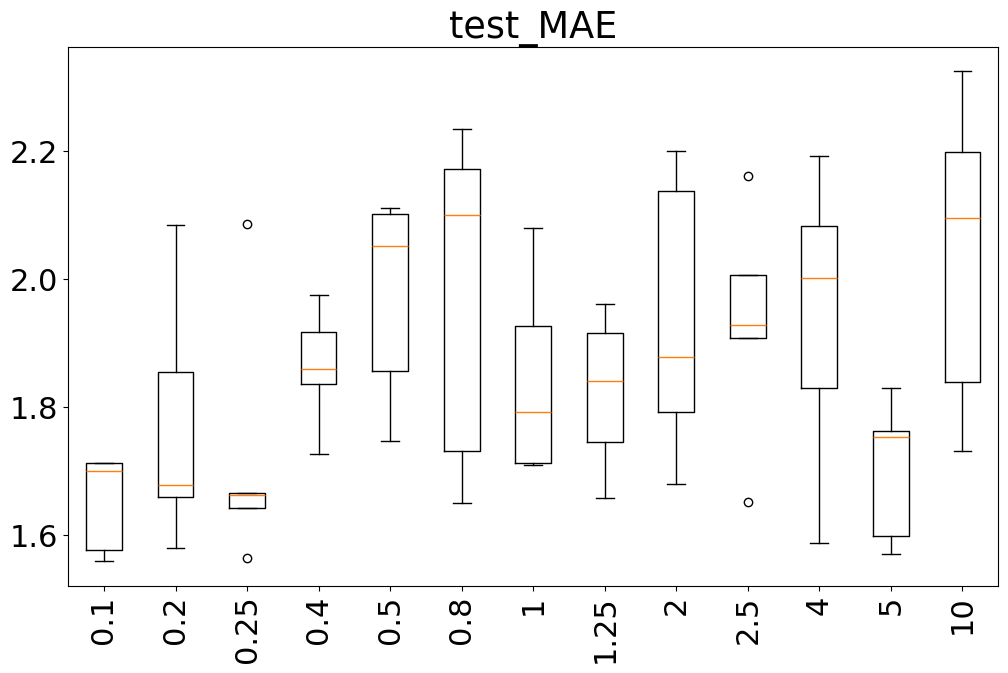

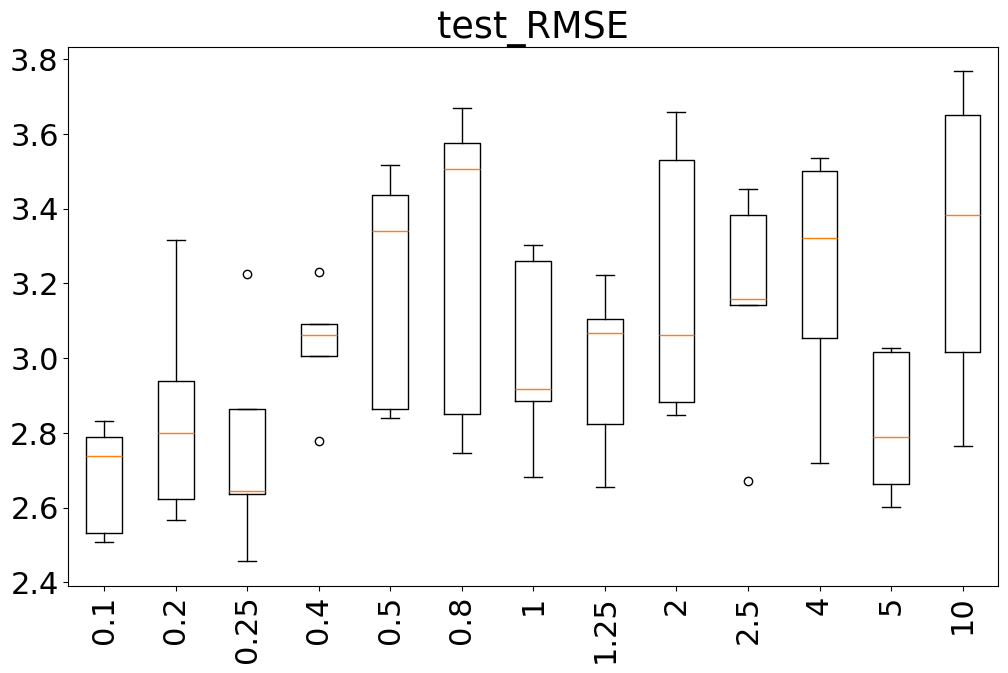

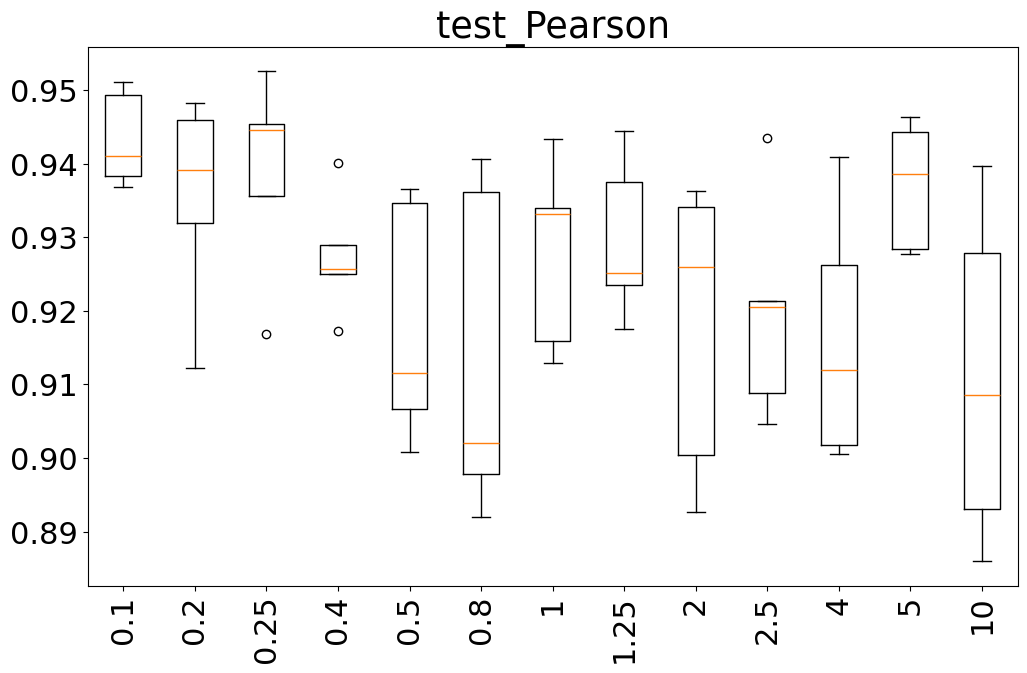

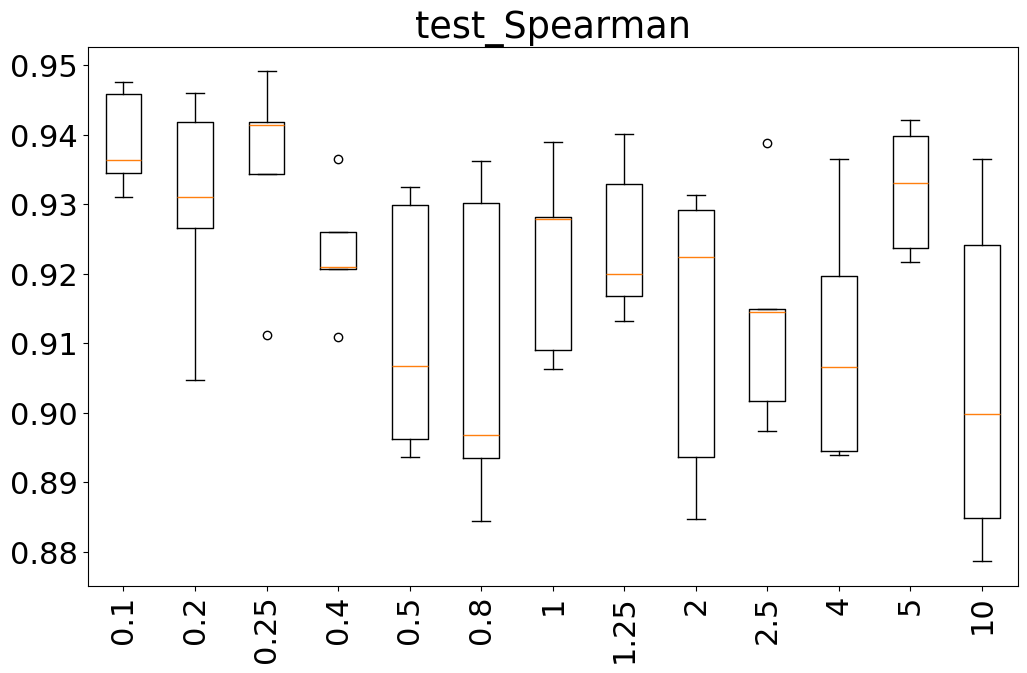

In [52]:
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = FAR_res[decay][lr][metric].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for para in range(13):
        paraname = paras[para]
        params[metric][paraname]={}
        evals[metric][paraname]={}
        evals[metric][paraname]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][paraname]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5):
            params[metric][paraname][replica]={}
            params[metric][paraname][replica]['decay']=-1
            params[metric][paraname][replica]['lr']=-1
            for decay in decays:
                lrs = FAR_res[decay].keys()
                for lr in lrs:
                    for i in range(epochs):
                        current = FAR_res[decay][lr][metric.replace('test','valid')][replica, para, i]
                        old = evals[metric][paraname]['valid'][replica]
                        if metric_isbetter(metric, old, current):
                            current_test = FAR_res[decay][lr][metric][replica, para, i]
                            evals[metric][paraname]['valid'][replica] = current
                            evals[metric][paraname]['test'][replica] = current_test
                            params[metric][paraname][replica]['decay'] = decay
                            params[metric][paraname][replica]['lr'] = lr
print(evals)
print(params)
print(paras)
boxvalues={}
for metric in eval_metrics:
#     print(metric)
    output = ''
    boxvalues[metric] = []
    for paraname in paras:
        values = evals[metric][paraname]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
        boxvalues[metric].append(values)
    print(output)
    
for metric in eval_metrics:
    plt.figure(figsize=(12,7))
    plt.boxplot(boxvalues[metric])
    plt.title(metric)
    plt.xticks(np.arange(1,14), paras, rotation=90)
    fname = '../Results/'+dataname + '_' + metric + '_sensitivity.pdf'
    plt.savefig(fname,format='pdf')
    
# FAR_id = -2
# for metric in eval_metrics:
# #     print(metric)
#     output = ''
#     maxvalue = []
#     for baseline in baselines:
#         values = evals[metric][baseline]['test']
#         mean = np.mean(values)
#         mean_baseline = np.mean(evals[metric]['MAE (vanilla)']['test'])
#         if metric.split('_')[1] in ['MAE','RMSE']:
#             value = (mean_baseline-mean)/mean_baseline * 100
#         else:
#             value = (mean-mean_baseline)/mean_baseline * 100
#         out = str(np.around(value, 3))+'\t'
#         output += out
#         maxvalue.append(value)
# #     print(output)
# #     print(np.around(max(maxvalue), 2))
#     improve = np.around(maxvalue[FAR_id], 2)
#     subopt = baselines[np.argmax(maxvalue[:FAR_id])]
#     mean_subopt = np.mean(evals[metric][subopt]['test'])
#     tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
#     gain = np.around(tmp, 2)
#     ttest1 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric]['MAE (vanilla)']['test'])
#     ttest2 = mstats.ttest_ind(evals[metric]['FAR']['test'], evals[metric][subopt]['test'])
#     pvalue1 = np.around(ttest1[1], 2)
#     pvalue2 = np.around(ttest2[1], 2)
#     print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

In [80]:
# baselines = ['MAE (vanilla)','MSE', 'Huber', 'focal (MAE)', 'focal (MSE)', 'ConR', 'FAR']
baselines = ['MAE (vanilla)','MSE', 'Huber', 'focal (MAE)', 'focal (MSE)', 'ranksim', 'RNC', 'ConR', 'FAR']#, 'MAE + Pearson'] #'FAR-LOG', 'MAE + Pearson']
# namemap = {'MAE + Pearson': 'pearson', 'MAE (vanilla)':'l1', 'MSE':'MSE', 'Huber':'huber', 'focal (MAE)':'focal-l1', 'focal (MSE)':'focal-mse', 'ranksim':'ranksim', 'RNC':'RNC', 'ConR':'ConR', 'FAR':'FAR', 'FAR-LOG':'pearson-dro'}
namemap = {'MAE + Pearson': 'pearson', 'MAE (vanilla)':'l1', 'MSE':'MSE', 'Huber':'huber', 'focal (MAE)':'focal-l1', 'focal (MSE)':'focal-mse', 'ranksim':'ranksim', 'RNC':'RNC', 'ConR':'ConR', 'FAR':'FARLOG-05-1-2', 'FAR-LOG':'pearson-dro'}
dataname = 'abalone'
basic_path = '../Code/ContrastiveRegression/results/abalone_l1_lr=1e-2_decay=1e-4.out'.replace('abalone',dataname)
metrics = ['time']
results = {}
for baseline in baselines:
    results[baseline] = {}
    res = {}
    for metric in metrics:
        res[metric] = []
    fpath = basic_path.replace('l1', 'time_'+ namemap[baseline])
    f = open(fpath, "r")
    while(True):
        line = f.readline()
        if not line:
            break
        elems = line.split(' ')
        values = elems[0].split('=')
        if values[0] in ['Epoch']:
            for elem in elems:
                values = elem.split('=')
                if values[0] in metrics:
                    res[values[0]].append(float(values[1].strip('\n').strip(',')))
    for metric in metrics:
        res[metric] = np.array(res[metric]).reshape(5, 3, -1)
    results[baseline]= res
print(results)

{'MAE (vanilla)': {'time': array([[[0.1127, 0.0843, 0.0931, ..., 0.0846, 0.0872, 0.085 ],
        [0.0849, 0.087 , 0.0857, ..., 0.0848, 0.0849, 0.0893],
        [0.0855, 0.0883, 0.0918, ..., 0.0859, 0.0899, 0.0845]],

       [[0.0846, 0.0905, 0.0861, ..., 0.0865, 0.0871, 0.084 ],
        [0.0863, 0.0881, 0.0861, ..., 0.0871, 0.088 , 0.0921],
        [0.0866, 0.0839, 0.0861, ..., 0.0916, 0.0905, 0.1001]],

       [[0.0848, 0.0902, 0.0844, ..., 0.0983, 0.0861, 0.0908],
        [0.1009, 0.0845, 0.0983, ..., 0.0881, 0.0865, 0.0854],
        [0.0905, 0.0916, 0.0866, ..., 0.0844, 0.0949, 0.0854]],

       [[0.0973, 0.0984, 0.0881, ..., 0.084 , 0.0923, 0.0843],
        [0.0896, 0.0949, 0.0853, ..., 0.0987, 0.0854, 0.0952],
        [0.0851, 0.0937, 0.0912, ..., 0.0915, 0.0864, 0.0946]],

       [[0.0979, 0.0956, 0.0873, ..., 0.0881, 0.0874, 0.0858],
        [0.0861, 0.087 , 0.0917, ..., 0.0933, 0.0881, 0.0925],
        [0.0944, 0.0892, 0.1075, ..., 0.1052, 0.0862, 0.0994]]])}, 'MSE': {'time': 

0.09(0.005)	0.091(0.006)	0.09(0.005)	0.092(0.006)	0.092(0.006)	0.111(0.006)	0.396(0.025)	0.106(0.006)	0.089(0.005)	


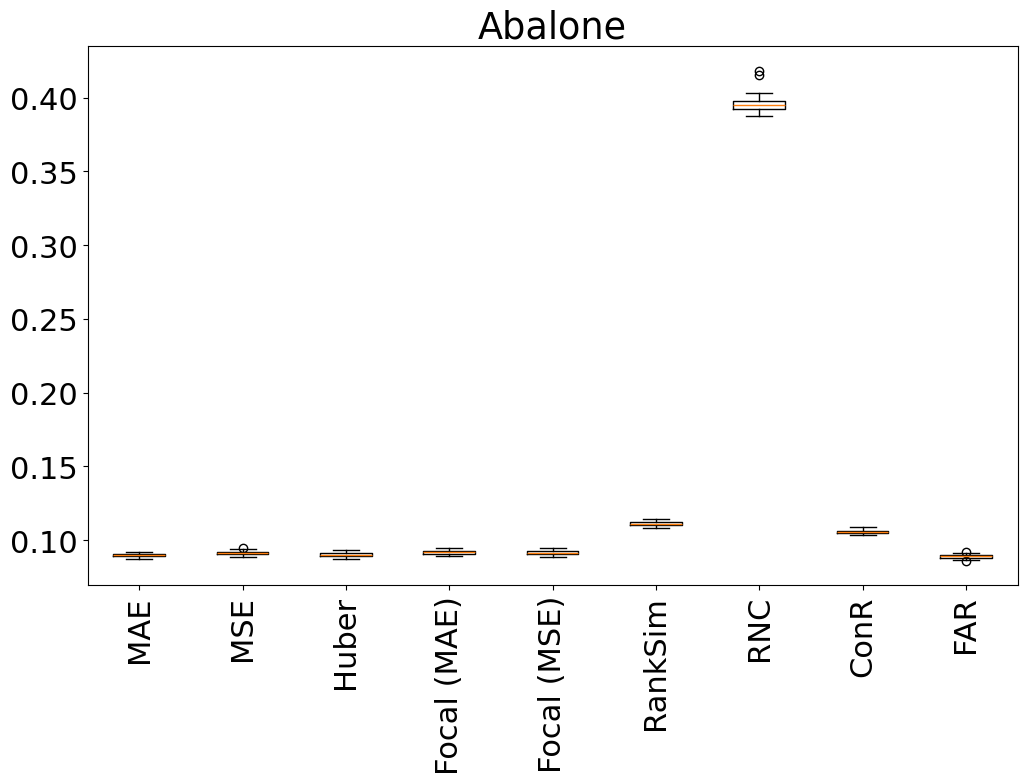

In [81]:
boxvalues=[]
for baseline in baselines:
    values = results[baseline]['time']
    if baseline == 'RNC':
        values = values[:,:,:50]
    boxvalues.append(values.mean(axis=0).mean(axis=0))
plt.figure(figsize=(12,7))
plt.boxplot(boxvalues)
dataname_map = {'wine':'Wine Quality', 'abalone':'Abalone', 'parkinson-motor':'Parkinson (Motor)', 'parkinson-total':'Parkinson (Total)'}
dataname_map['supercon'] = 'Super Conductivity'
plt.title(dataname_map[dataname])
names = ['MAE','MSE', 'Huber', 'Focal (MAE)', 'Focal (MSE)', 'RankSim', 'RNC', 'ConR', 'FAR']
plt.xticks(np.arange(1,10), names, rotation=90)
fname = '../Results/'+dataname + '_time.pdf'
plt.savefig(fname,format='pdf')
output = ''
for baseline in baselines:
    values = results[baseline]['time']
    if baseline == 'RNC':
        values = values[:,:,:50]
    mean = np.around(np.mean(values), 3)
    std = np.around(np.std(values), 3)
    out = str(mean) + '(' + str(std) + ')\t'
    output += out
print(output)

[0.3648565  0.36283252 0.3633672  0.38167417 0.36688286]


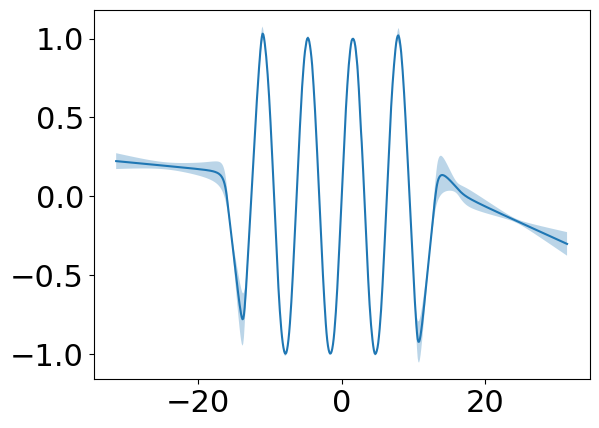

In [3]:
tmp=np.load('./FAR/data/sine.npz')
X = tmp['X'].squeeze()
tmp=np.load('./FAR/results/sin_FAR_para=0.5_lr=0.01_decay=0.0_layers=4.npz')
test_MAE = tmp['test_MAE']
pred_Y = np.concatenate(tmp['pred_Y'], axis=1)
print(test_MAE)
m_Y = pred_Y.mean(axis=1)
std_Y = pred_Y.std(axis=1)
plt.figure()
plt.plot(X,m_Y)
plt.fill_between(X,m_Y-std_Y, m_Y+std_Y, alpha=0.3)

layers=2 MAE lr=0.01 para=0.1
layers=2 MSE lr=0.01 para=0.1
layers=2 RNC lr=0.01 para=4
layers=2 Pearson lr=0.01 para=0.1
layers=2 FAR lr=0.01 para=0.5
layers=4 MAE lr=0.01 para=0.1
layers=4 MSE lr=0.01 para=0.1
layers=4 RNC lr=0.01 para=4
layers=4 Pearson lr=0.01 para=0.1
layers=4 FAR lr=0.01 para=0.5
layers=6 MAE lr=0.01 para=0.1
layers=6 MSE lr=0.01 para=0.1
layers=6 RNC lr=0.01 para=4
layers=6 Pearson lr=0.01 para=0.1
layers=6 FAR lr=0.01 para=2
layers=8 MAE lr=0.01 para=0.1
layers=8 MSE lr=0.01 para=0.1
layers=8 RNC lr=0.01 para=1
layers=8 Pearson lr=0.01 para=0.1
layers=8 FAR lr=0.01 para=2
layers=10 MAE lr=0.01 para=0.1


/local/scratch/dixzhu/slrmtmp.42629200/ipykernel_102758/1714104226.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


layers=10 MSE lr=0.01 para=0.1
layers=10 RNC lr=0.01 para=4
layers=10 Pearson lr=0.01 para=0.1
layers=10 FAR lr=0.01 para=1


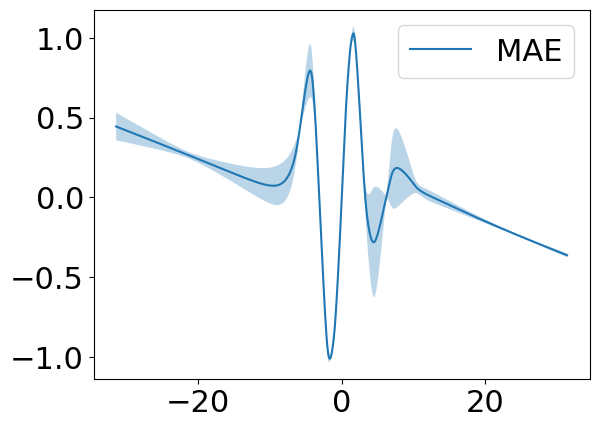

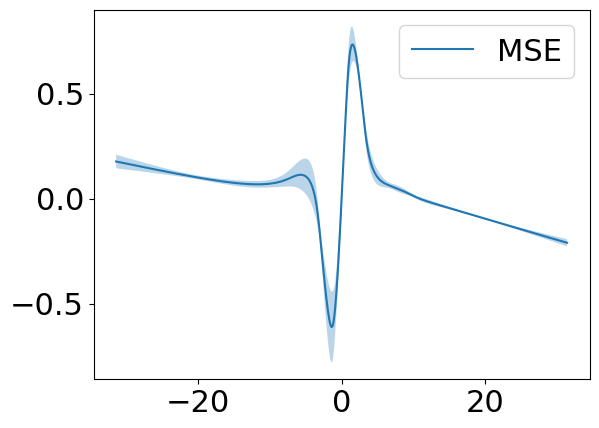

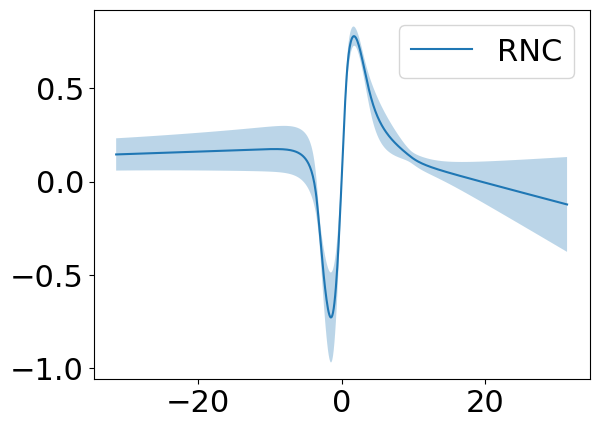

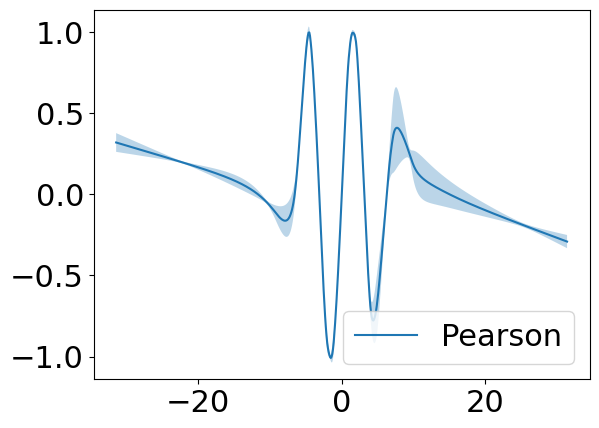

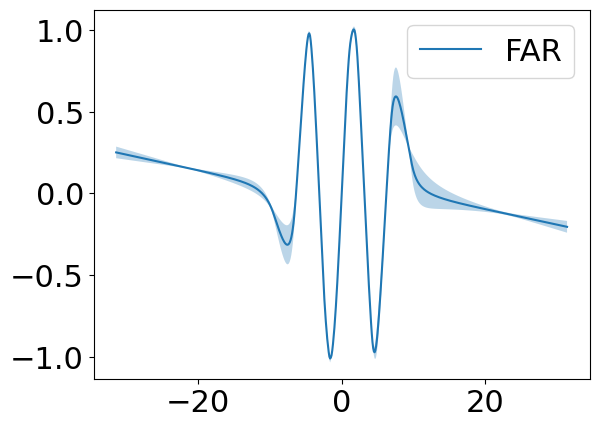

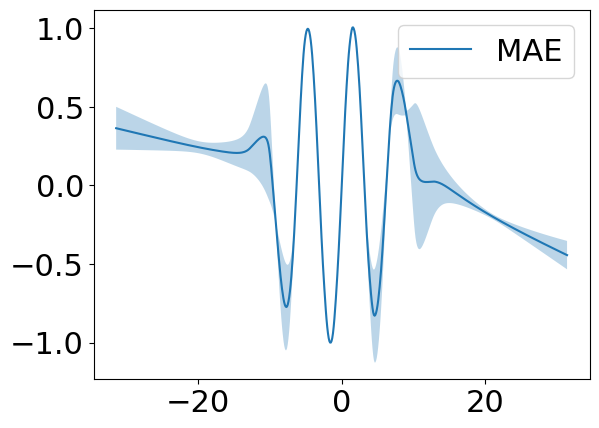

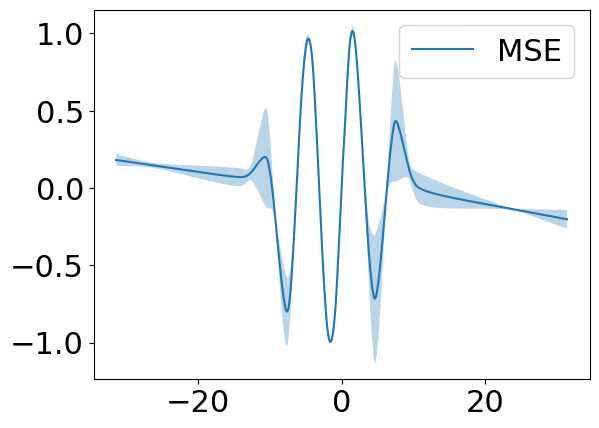

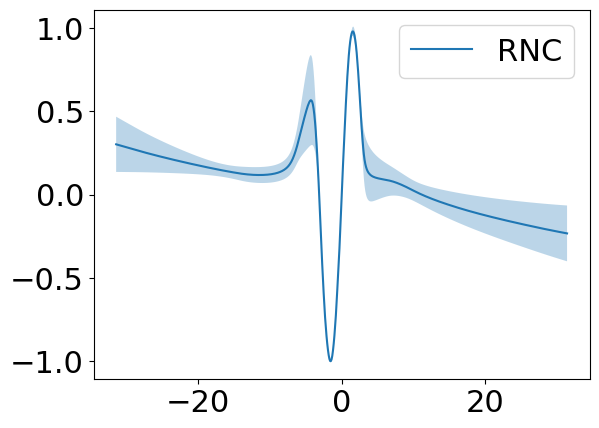

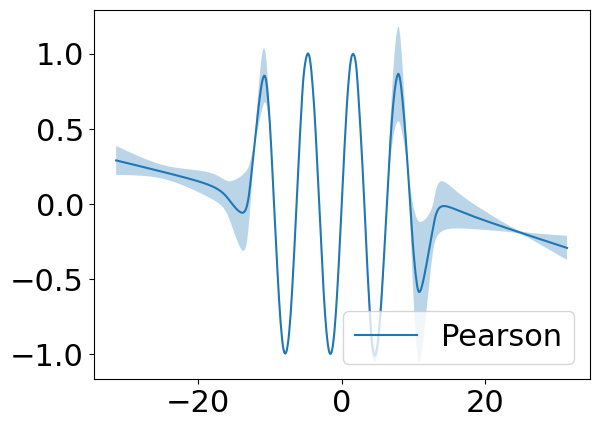

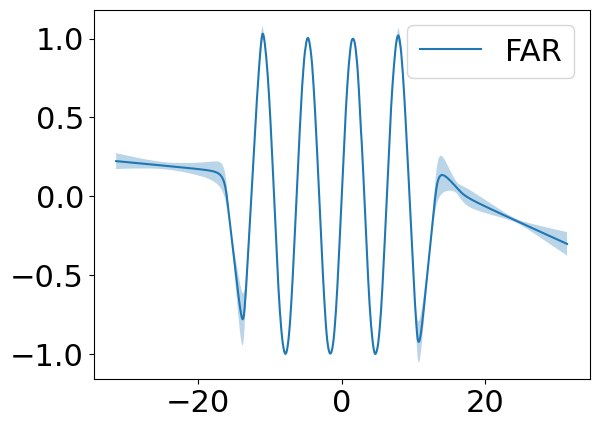

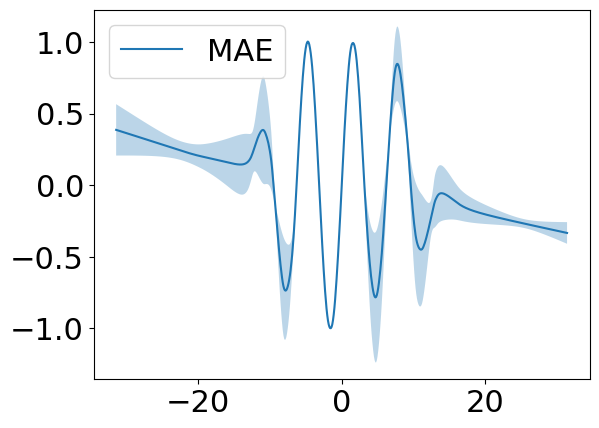

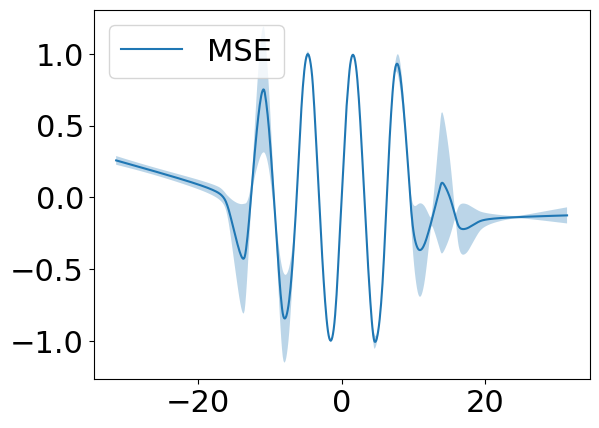

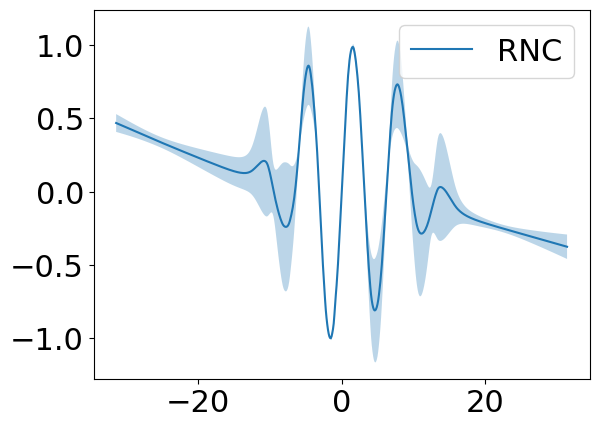

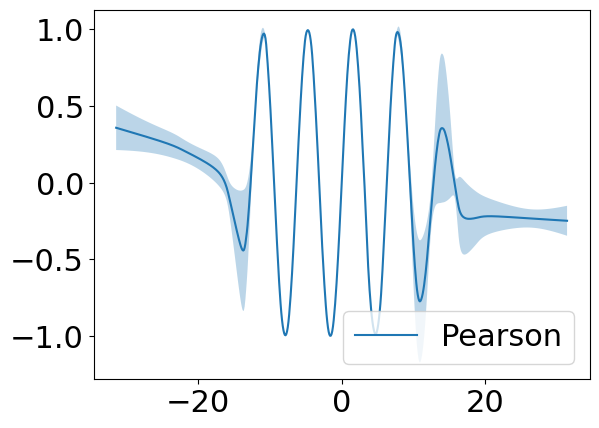

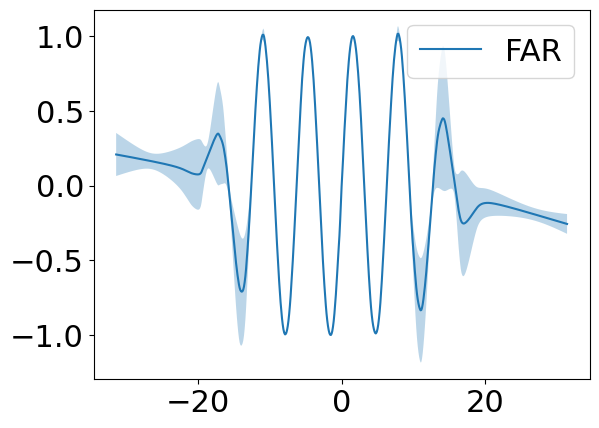

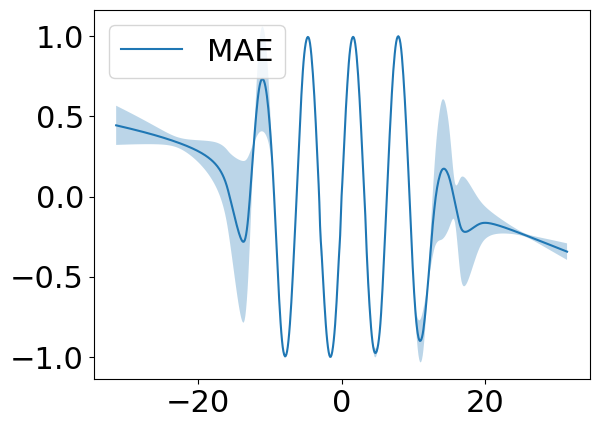

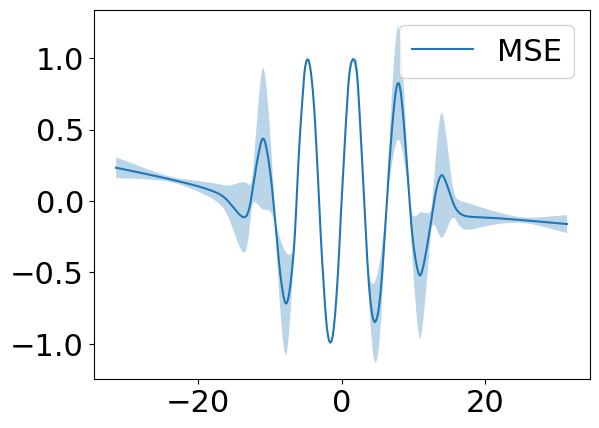

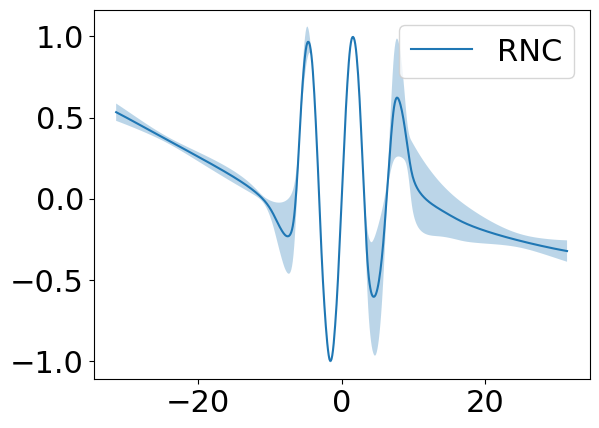

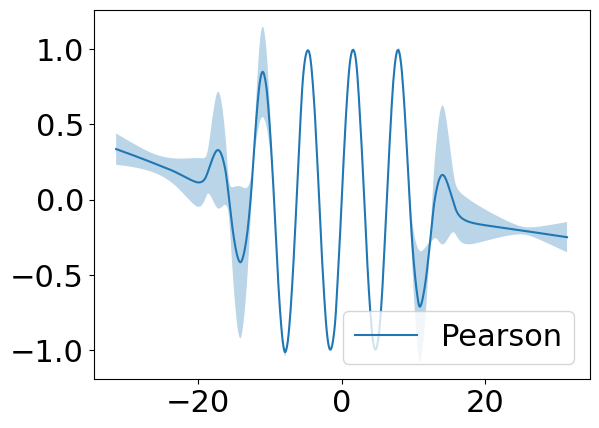

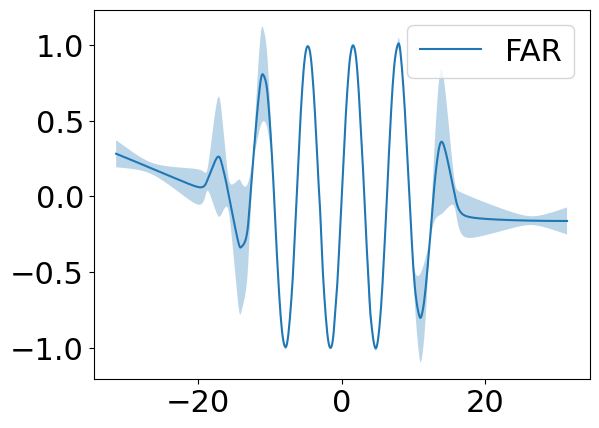

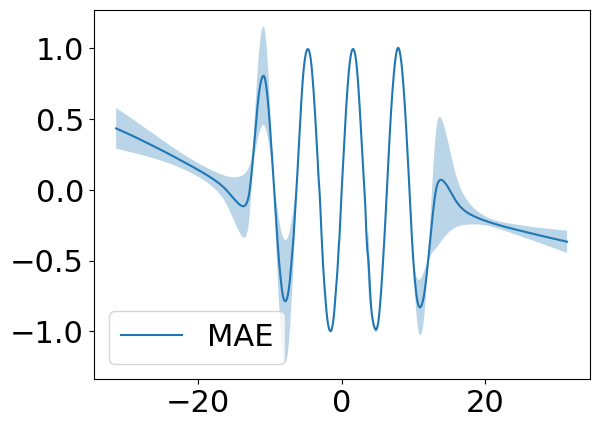

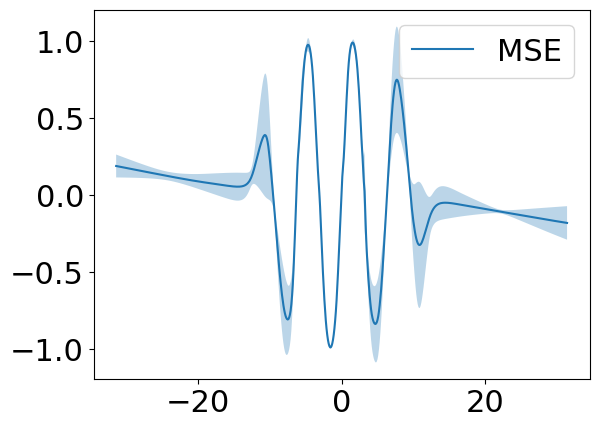

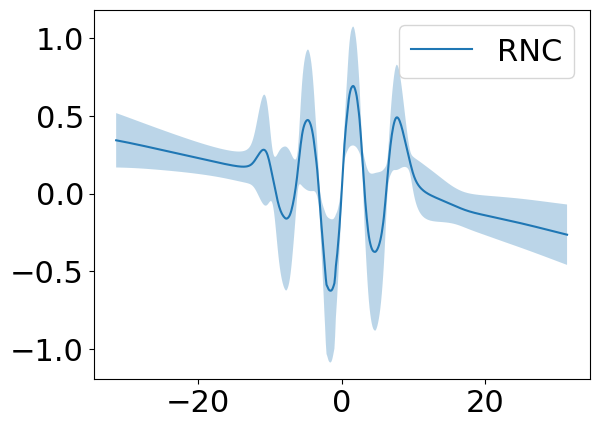

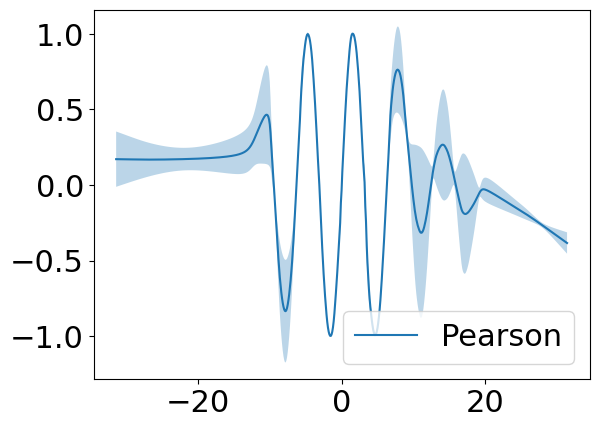

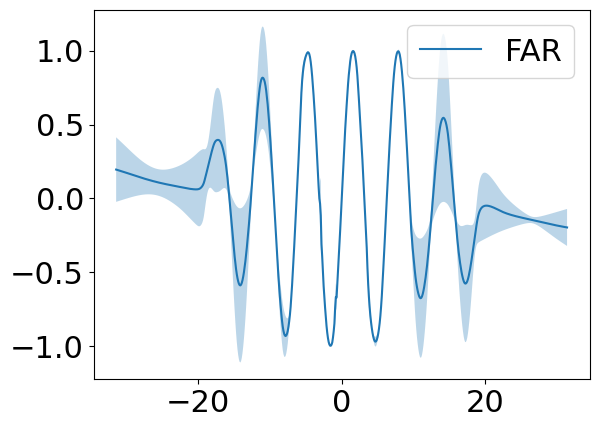

In [35]:
baselines = ['MAE','MSE','RNC','Pearson','FAR']
dataname = 'sin'
tmp=np.load('./FAR/data/sine.npz')
X = tmp['X'].squeeze()
basic_path = 'FAR/results/sin_FAR_para=0.5_lr=0.01_decay=0.0_layers=2.npz'.replace('sin',dataname)
layers = ['layers=2','layers=4','layers=6','layers=8','layers=10']
lrs = ['lr=0.01', 'lr=0.001']
results = {}
paras = {'MAE':['para=0.1', 'para=0.5', 'para=0.9'], 'RNC':['para=1', 'para=2', 'para=4'], 'FAR':['para=0.5', 'para=1', 'para=2']}
paras['MSE']=paras['MAE']
paras['Pearson']=paras['MAE']
for layer in layers:
    for baseline in baselines:
        test_MAE = 1e10
        best_pred = []
        best_lr = -1e10
        best_para = -1e10
        for lr in lrs:
            for para in paras[baseline]:
                fpath = basic_path.replace('_FAR', '_'+baseline).replace('lr=0.01',lr).replace('para=0.5', para).replace('layers=2',layer)
                tmp = np.load(fpath)
                mae = tmp['test_MAE']
                if np.mean(mae) < test_MAE:
                    test_MAE = np.mean(mae)
                    best_pred = np.concatenate(tmp['pred_Y'], axis=1)
                    best_lr = lr
                    best_para = para
        plt.figure()
        m_Y = best_pred.mean(axis=1)
        std_Y = best_pred.std(axis=1)
        plt.plot(X, m_Y, label=baseline)
        plt.fill_between(X,m_Y-std_Y, m_Y+std_Y, alpha=0.3)
        plt.legend()
        fname = 'FAR/figures/'+dataname+'_'+layer+'_'+baseline+'.pdf'
        plt.savefig(fname, format='pdf')
        print(layer, baseline, best_lr, best_para)


In [18]:
# baselines = ['b', 'c', 'a', 'b+c', 'a+b', 'a+c', 'a+b+c']
baselines = ['MAE','MSE','Huber','focal-MAE','focal-MSE','ranksim','RNC','ConR','FAR']
dataname = 'IC50'
basic_path = 'FAR/results/abalone_l1_lr=1e-1_decay=1e-3.out'.replace('abalone',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
if dataname in ['supercon']:
    lrs = ['1e-1', '1e-2','1e-3', '1e-4', '1e-5']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    print(baseline)
    for decay in decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', baseline).replace('lr=1e-1','lr='+lr).replace('decay=1e-3','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                res[metric] = np.array(res[metric]).reshape(5, 3,-1)
            results[baseline][decay][lr] = res
print(results)

MAE
MSE
Huber
focal-MAE
focal-MSE
ranksim
RNC
ConR
FAR
{'MAE': {'1e-3': {'1e-1': {'train_MAE': array([[[0.8085, 0.8073, 0.802 , ..., 0.783 , 0.7882, 0.7806],
        [0.8032, 0.8062, 0.8017, ..., 0.7907, 0.7822, 0.7889],
        [0.8099, 0.8102, 0.8046, ..., 0.7756, 0.783 , 0.7837]],

       [[0.7916, 0.7965, 0.7963, ..., 0.7816, 0.7894, 0.782 ],
        [0.8069, 0.8048, 0.7954, ..., 0.7843, 0.7722, 0.7752],
        [0.7953, 0.7943, 0.7922, ..., 0.773 , 0.7792, 0.7736]],

       [[0.8167, 0.809 , 0.8143, ..., 0.7962, 0.7877, 0.7895],
        [0.8134, 0.8115, 0.8145, ..., 0.7923, 0.7897, 0.7912],
        [0.8126, 0.8057, 0.8064, ..., 0.7998, 0.8016, 0.7907]],

       [[0.8017, 0.794 , 0.7994, ..., 0.7843, 0.7828, 0.7802],
        [0.8069, 0.8073, 0.8073, ..., 0.7857, 0.7875, 0.783 ],
        [0.797 , 0.7994, 0.8023, ..., 0.7817, 0.7831, 0.7868]],

       [[0.7973, 0.801 , 0.7956, ..., 0.7747, 0.7788, 0.7753],
        [0.8014, 0.7987, 0.7952, ..., 0.7812, 0.775 , 0.7811],
        [0.8019

In [19]:
# farname, vanillaname = 'a+b+c', 'b'
farname, vanillaname = 'FAR', 'MAE'


eval_metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
evals = {}
epochs = results[farname]['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
#                 lrs = ['1e-2','1e-3','1e-4','1e-5']
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)

for metric in eval_metrics:
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric][vanillaname]['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)

    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][vanillaname]['test'])
    ttest2 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'train_MAE': {'MAE': {'valid': array([0.7732, 0.7662, 0.7827, 0.7716, 0.7647]), 'test': array([0.7732, 0.7662, 0.7827, 0.7716, 0.7647])}, 'MSE': {'valid': array([0.7746, 0.7725, 0.7927, 0.7807, 0.771 ]), 'test': array([0.7746, 0.7725, 0.7927, 0.7807, 0.771 ])}, 'Huber': {'valid': array([0.7746, 0.7701, 0.7853, 0.7751, 0.7696]), 'test': array([0.7746, 0.7701, 0.7853, 0.7751, 0.7696])}, 'focal-MAE': {'valid': array([0.7751, 0.7663, 0.7857, 0.7717, 0.7675]), 'test': array([0.7751, 0.7663, 0.7857, 0.7717, 0.7675])}, 'focal-MSE': {'valid': array([0.7744, 0.7753, 0.7967, 0.7839, 0.7795]), 'test': array([0.7744, 0.7753, 0.7967, 0.7839, 0.7795])}, 'ranksim': {'valid': array([0.778 , 0.7734, 0.791 , 0.7816, 0.7737]), 'test': array([0.778 , 0.7734, 0.791 , 0.7816, 0.7737])}, 'RNC': {'valid': array([0.7829, 0.7731, 0.7969, 0.7829, 0.7824]), 'test': array([0.7829, 0.7731, 0.7969, 0.7829, 0.7824])}, 'ConR': {'valid': array([0.752 , 0.7552, 0.768 , 0.765 , 0.7178]), 'test': array([0.752 , 0.7552, 0

In [20]:
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = results[farname]['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
#                 lrs = ['1e-2','1e-3','1e-4','1e-5']
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric.replace('test','valid')][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)

for metric in eval_metrics:
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric][vanillaname]['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)

    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][vanillaname]['test'])
    ttest2 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'test_MAE': {'MAE': {'valid': array([0.7823, 0.8   , 0.749 , 0.7927, 0.8101]), 'test': array([0.8168, 0.8194, 0.8188, 0.8224, 0.8225])}, 'MSE': {'valid': array([0.7929, 0.8142, 0.7653, 0.7982, 0.8132]), 'test': array([0.8339, 0.8269, 0.83  , 0.8287, 0.8237])}, 'Huber': {'valid': array([0.7833, 0.8012, 0.7519, 0.7935, 0.8099]), 'test': array([0.8179, 0.8197, 0.8218, 0.8228, 0.8219])}, 'focal-MAE': {'valid': array([0.7819, 0.8002, 0.7482, 0.793 , 0.8111]), 'test': array([0.8189, 0.8198, 0.8196, 0.8231, 0.8221])}, 'focal-MSE': {'valid': array([0.7929, 0.8162, 0.766 , 0.7984, 0.815 ]), 'test': array([0.834 , 0.8312, 0.8308, 0.83  , 0.8274])}, 'ranksim': {'valid': array([0.7806, 0.8012, 0.752 , 0.795 , 0.8123]), 'test': array([0.8192, 0.8226, 0.817 , 0.8212, 0.8207])}, 'RNC': {'valid': array([0.7876, 0.8056, 0.763 , 0.794 , 0.8099]), 'test': array([0.829 , 0.8223, 0.8288, 0.8274, 0.8272])}, 'ConR': {'valid': array([0.7786, 0.7965, 0.743 , 0.7865, 0.8059]), 'test': array([0.8155, 0.8126, 0.

In [36]:
import pandas as pd
from scipy.stats import rankdata 

In [41]:
ablation = pd.read_excel('FAR/ablation-far.xlsx', header=None)
print(ablation)

                0              1              2              3              4  \
0    0.631(0.008)   1.251(0.722)   1.587(0.799)   0.609(0.009)   0.611(0.002)   
1    0.821(0.012)   1.425(0.686)   1.914(0.746)   0.771(0.006)   0.786(0.006)   
2    0.346(0.043)   0.507(0.004)   0.507(0.008)   0.461(0.013)   0.503(0.009)   
3    0.385(0.014)   0.514(0.004)   0.519(0.008)   0.467(0.022)   0.518(0.008)   
4    1.505(0.018)     8.81(0.29)   7.167(1.798)   1.493(0.012)   1.494(0.019)   
5    2.174(0.017)    9.115(0.31)   7.987(1.473)   2.161(0.011)   2.164(0.029)   
6    0.736(0.003)   0.743(0.006)   0.741(0.004)   0.746(0.003)   0.742(0.008)   
7     0.77(0.004)   0.777(0.004)   0.776(0.005)   0.776(0.004)   0.778(0.003)   
8    3.358(0.045)  27.563(0.902)   24.393(2.48)   2.746(0.068)    2.648(0.13)   
9     5.384(0.05)  28.306(1.115)  26.489(1.795)    4.214(0.14)   4.402(0.253)   
10   0.866(0.002)   0.934(0.012)   0.951(0.004)   0.924(0.005)    0.912(0.01)   
11   0.846(0.003)   0.922(0.

In [47]:
processed_data = []
ct = 0
for line in ablation.values:
    new_line = []
    for elem in line:
        new_line.append(float(elem.split('(')[0]))
    new_line = np.expand_dims(np.array(new_line),axis=0)
    if ct%4 >= 2:
        new_line *= -1
    processed_data.append(new_line)
    ct += 1
processed_data = np.concatenate(processed_data, axis=0)
print(processed_data)

[[ 0.631  1.251  1.587  0.609  0.611  1.206  0.596]
 [ 0.821  1.425  1.914  0.771  0.786  1.42   0.756]
 [-0.346 -0.507 -0.507 -0.461 -0.503 -0.5   -0.503]
 [-0.385 -0.514 -0.519 -0.467 -0.518 -0.513 -0.511]
 [ 1.505  8.81   7.167  1.493  1.494  7.235  1.494]
 [ 2.174  9.115  7.987  2.161  2.164  7.595  2.147]
 [-0.736 -0.743 -0.741 -0.746 -0.742 -0.74  -0.748]
 [-0.77  -0.777 -0.776 -0.776 -0.778 -0.777 -0.778]
 [ 3.358 27.563 24.393  2.746  2.648 26.861  2.64 ]
 [ 5.384 28.306 26.489  4.214  4.402 27.363  4.258]
 [-0.866 -0.934 -0.951 -0.924 -0.912 -0.939 -0.922]
 [-0.846 -0.922 -0.942 -0.911 -0.897 -0.931 -0.907]
 [ 2.277 19.211 16.788  1.672  1.853 19.188  1.652]
 [ 3.927 19.687 19.373  2.701  3.116 19.709  2.68 ]
 [-0.875 -0.942 -0.944 -0.942 -0.919 -0.943 -0.943]
 [-0.868 -0.939 -0.94  -0.938 -0.913 -0.94  -0.939]
 [ 6.577 20.445 14.27   6.293  6.238 18.616  6.257]
 [11.815 23.676 17.094 10.719 10.935 21.514 10.745]
 [-0.94  -0.95  -0.947 -0.95  -0.948 -0.951 -0.949]
 [-0.942 -0.

In [52]:
ranks=rankdata(processed_data, method='average',axis=1)
print(ranks)
print(np.around(ranks.mean(axis=0), 3))

[[4.  6.  7.  2.  3.  5.  1. ]
 [4.  6.  7.  2.  3.  5.  1. ]
 [7.  1.5 1.5 6.  3.5 5.  3.5]
 [7.  3.  1.  6.  2.  4.  5. ]
 [4.  7.  5.  1.  2.5 6.  2.5]
 [4.  7.  6.  2.  3.  5.  1. ]
 [7.  3.  5.  2.  4.  6.  1. ]
 [7.  3.5 5.5 5.5 1.5 3.5 1.5]
 [4.  7.  5.  3.  2.  6.  1. ]
 [4.  7.  5.  1.  3.  6.  2. ]
 [7.  3.  1.  4.  6.  2.  5. ]
 [7.  3.  1.  4.  6.  2.  5. ]
 [4.  7.  5.  2.  3.  6.  1. ]
 [4.  6.  5.  2.  3.  7.  1. ]
 [7.  4.5 1.  4.5 6.  2.5 2.5]
 [7.  3.5 1.5 5.  6.  1.5 3.5]
 [4.  7.  5.  3.  1.  6.  2. ]
 [4.  7.  5.  1.  3.  6.  2. ]
 [7.  2.5 6.  2.5 5.  1.  4. ]
 [5.  5.  7.  3.  1.  5.  2. ]
 [1.5 7.  5.  4.  3.  6.  1.5]
 [4.  7.  5.  3.  2.  6.  1. ]
 [7.  5.  4.  6.  1.5 1.5 3. ]
 [7.  5.  2.  6.  1.  3.  4. ]]
[5.312 5.146 4.229 3.354 3.125 4.458 2.375]
